In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import plotly.express as px
import plotly.graph_objects as go


import sys
import os

sys.path.append(os.path.abspath('../src'))
import utils as util

# Definindo tema e cores
cores_personalizadas = [util.barra_azul, util.barra_vermelha]

df = pd.read_csv('../data/databaseElisa.csv', sep=';', decimal=',', thousands='.', 
                 index_col=None)

df.tail()


,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
3065,11/05/2025,Silo,5,6,5,0,20.0,20.0,8.5,8.5,262.5
3066,12/05/2025,Santa Elisa,5,1,6,1,20.0,20.0,8.5,8.5,179.5
3067,12/05/2025,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0
3068,13/05/2025,Santa Elisa,9,2,6,1,20.0,20.0,8.5,8.5,279.5
3069,13/05/2025,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0


In [2]:

df['data'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')

data_inicio = pd.Timestamp('2025-04-01')


df_filtrado = df[df['data'] >= data_inicio].copy()


In [3]:
df_filtrado.head()

,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
2984,2025-04-01,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0
2985,2025-04-01,Silo,25,7,25,2,20.0,20.0,8.5,8.5,869.5
2986,2025-04-02,Santa Elisa,7,1,0,0,20.0,20.0,8.5,8.5,160.0
2987,2025-04-02,Silo,21,8,25,4,20.0,20.0,8.5,8.5,826.5
2988,2025-04-03,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0


In [4]:
df_filtrado.tail()

,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
3065,2025-05-11,Silo,5,6,5,0,20.0,20.0,8.5,8.5,262.5
3066,2025-05-12,Santa Elisa,5,1,6,1,20.0,20.0,8.5,8.5,179.5
3067,2025-05-12,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0
3068,2025-05-13,Santa Elisa,9,2,6,1,20.0,20.0,8.5,8.5,279.5
3069,2025-05-13,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0


In [5]:
util.generate_metadata(df_filtrado)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,data,datetime64[ns],0,0.0,43
1,almoco,int64,0,0.0,25
2,janta,int64,0,0.0,9
3,cafe,int64,0,0.0,15
4,lanche,int64,0,0.0,6
5,vlrAlmoco,float64,0,0.0,1
6,vlrJanta,float64,0,0.0,1
7,vlrCafe,float64,0,0.0,1
8,vlrLanche,float64,0,0.0,1
9,total,float64,0,0.0,64


In [6]:
# Descrição estatística das colunas numéricasdf
cols_to_describe = ['almoco', 'janta', 'cafe', 'lanche', 'vlrAlmoco', 'vlrJanta', 'vlrCafe', 'vlrLanche', 'total']

df_filtrado[cols_to_describe].describe()

,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
count,86.000000,86.000000,86.000000,86.000000,86.0,86.0,86.0,86.0,86.000000
mean,10.023256,3.720930,10.732558,0.383721,20.0,20.0,8.5,8.5,369.372093
std,6.444289,2.742481,9.927294,1.294046,0.0,0.0,0.0,0.0,253.641644
min,0.000000,0.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,0.000000
25%,5.000000,1.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,160.000000
50%,9.000000,4.000000,8.500000,0.000000,20.0,20.0,8.5,8.5,342.000000
75%,14.750000,6.000000,20.000000,0.000000,20.0,20.0,8.5,8.5,590.000000
max,26.000000,8.000000,28.000000,10.000000,20.0,20.0,8.5,8.5,901.000000


In [7]:
util.lista_valores_unicos(df_filtrado, 'fazenda')

,Coluna,Categoria,Cardinalidade,Porcentagem
0,fazenda,Santa Elisa,43,50.00%
1,fazenda,Silo,43,50.00%


In [8]:
df_filtrado.columns = df_filtrado.columns.str.strip().str.lower()

### Quantidade Total de Refeições por Fazenda

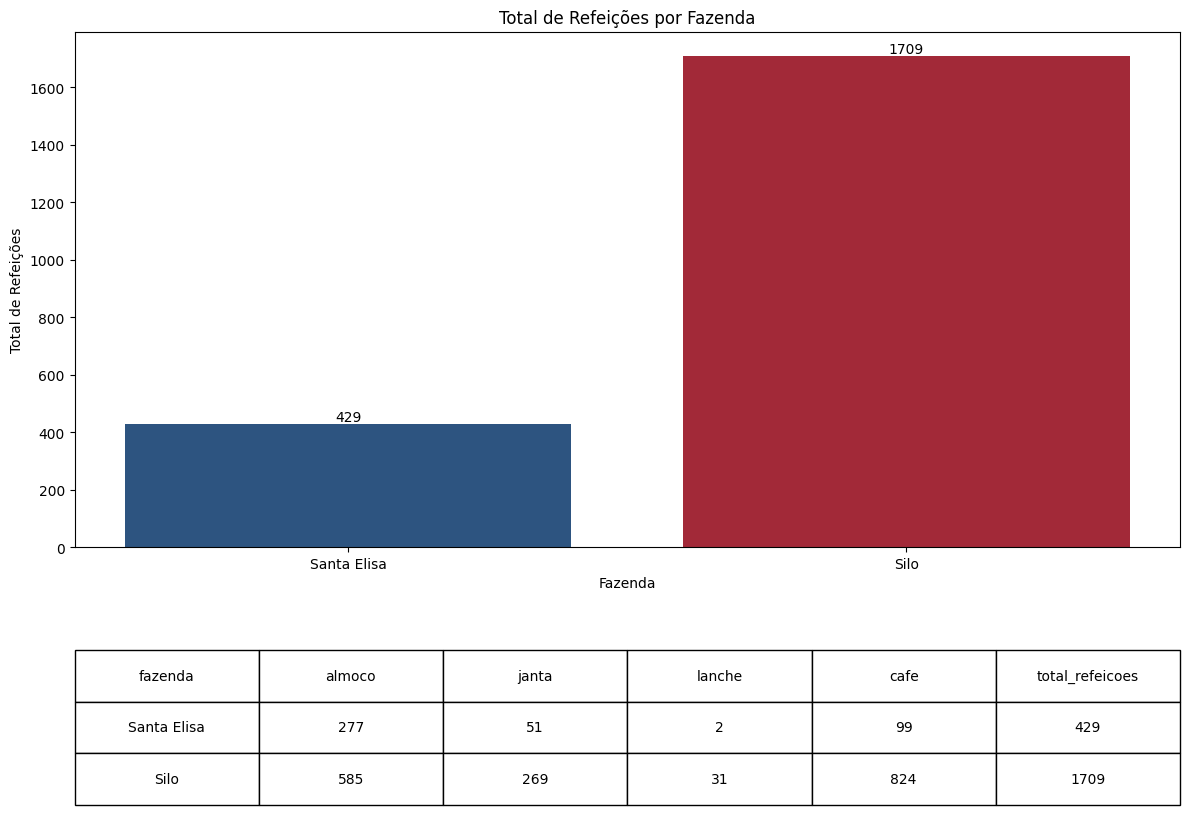

In [9]:
qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']
df_qtd_fazenda = df_filtrado.groupby('fazenda')[qtd_cols].sum().reset_index()
df_qtd_fazenda['total_refeicoes'] = df_qtd_fazenda[qtd_cols].sum(axis=1)

cores = [cores_personalizadas[i % len(cores_personalizadas)] for i in range(len(df_qtd_fazenda))]

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(df_qtd_fazenda['fazenda'], df_qtd_fazenda['total_refeicoes'], color=cores)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('Total de Refeições por Fazenda')
ax.set_xlabel('Fazenda')
ax.set_ylabel('Total de Refeições')
plt.xticks(rotation=0)

tabela_dados = df_qtd_fazenda[['fazenda', 'almoco', 'janta', 'lanche', 'cafe', 'total_refeicoes']]
tabela = plt.table(cellText=tabela_dados.values,
                   colLabels=tabela_dados.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.5, 1.0, 0.3])  

plt.subplots_adjust(bottom=0.3)  
plt.tight_layout()
plt.show()


### Evolução Temporal do Total de Vendas

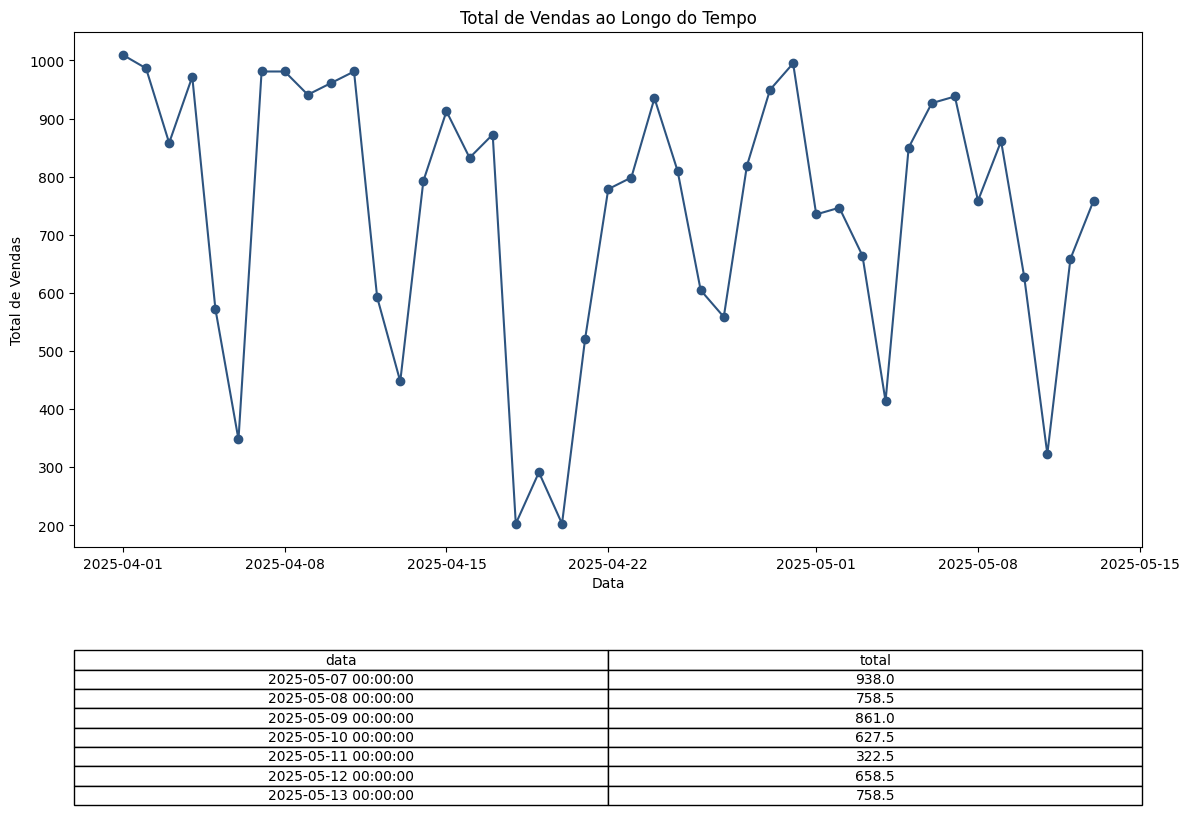

In [10]:
df_data_total = df_filtrado.groupby('data')['total'].sum().reset_index()

tabela_dados = df_data_total.tail(7)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_data_total['data'], df_data_total['total'], marker='o', color=util.barra_azul)
ax.set_title('Total de Vendas ao Longo do Tempo')
ax.set_xlabel('Data')
ax.set_ylabel('Total de Vendas')
plt.xticks(rotation=0)

tabela = plt.table(cellText=tabela_dados.values,
                   colLabels=tabela_dados.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.5, 1.0, 0.3])  # Ajuste conforme necessário

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()


### Comparativo de ticket médio (valor unitário) entre fazendas


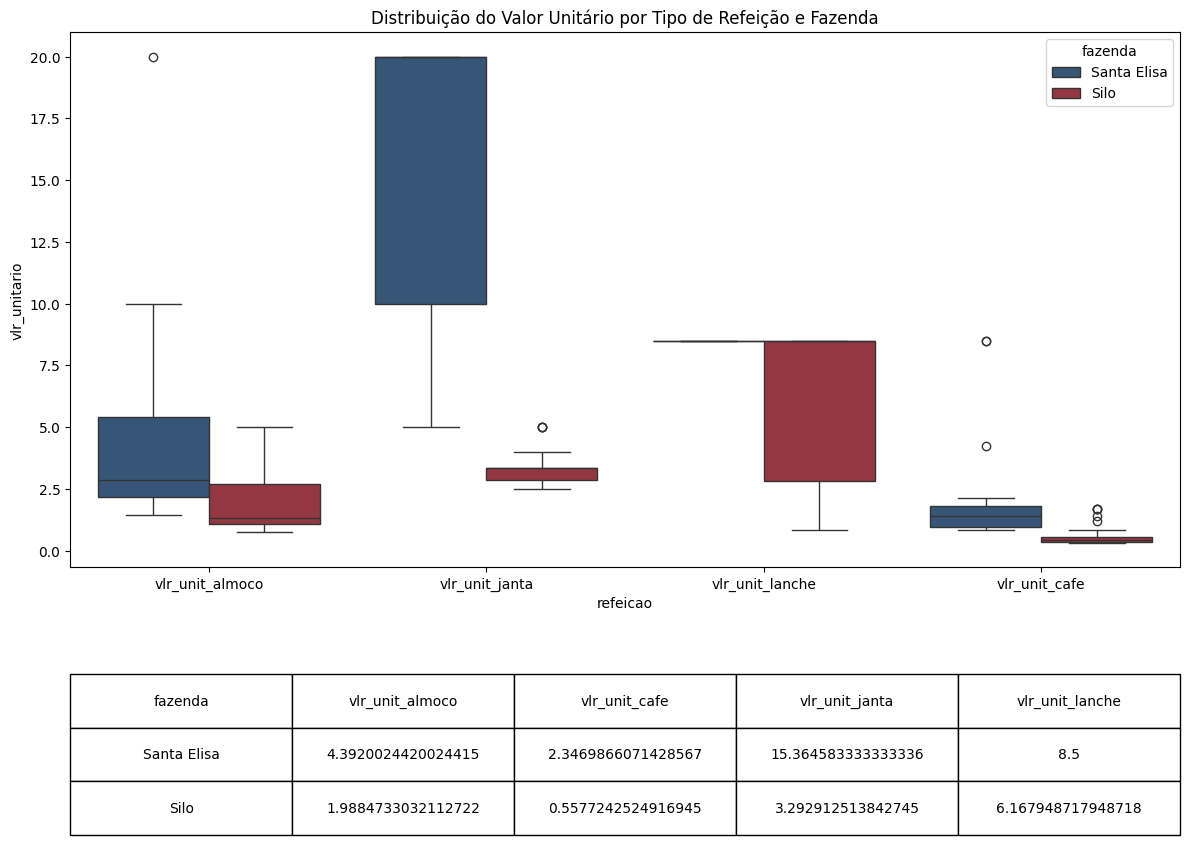

In [11]:
# Calcular valores unitários
df_filtrado['vlr_unit_almoco'] = df_filtrado['vlralmoco'] / df_filtrado['almoco'].replace(0, pd.NA)
df_filtrado['vlr_unit_janta'] = df_filtrado['vlrjanta'] / df_filtrado['janta'].replace(0, pd.NA)
df_filtrado['vlr_unit_lanche'] = df_filtrado['vlrlanche'] / df_filtrado['lanche'].replace(0, pd.NA)
df_filtrado['vlr_unit_cafe'] = df_filtrado['vlrcafe'] / df_filtrado['cafe'].replace(0, pd.NA)

# Reformular para formato longo (melt)
df_melt = df_filtrado.melt(
    id_vars=['fazenda'],
    value_vars=['vlr_unit_almoco', 'vlr_unit_janta', 'vlr_unit_lanche', 'vlr_unit_cafe'],
    var_name='refeicao',
    value_name='vlr_unitario'
)

# Criar figura
fig, ax = plt.subplots(figsize=(12, 8))

# Gráfico boxplot
sns.boxplot(data=df_melt, x='refeicao', y='vlr_unitario', hue='fazenda',
            palette=[util.barra_azul, util.barra_vermelha], ax=ax)

ax.set_title('Distribuição do Valor Unitário por Tipo de Refeição e Fazenda')
plt.xticks(rotation=0)

# Criar tabela com média dos valores por fazenda e refeição
df_tabela = df_melt.groupby(['fazenda', 'refeicao'])['vlr_unitario'].mean().reset_index()
tabela_pivot = df_tabela.pivot(index='fazenda', columns='refeicao', values='vlr_unitario').round(2).reset_index()

# Adicionar tabela abaixo do gráfico
tabela = plt.table(cellText=tabela_pivot.values,
                   colLabels=tabela_pivot.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.5, 1.0, 0.3])

# Ajustar layout
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Análise sazonal: média de vendas por mês

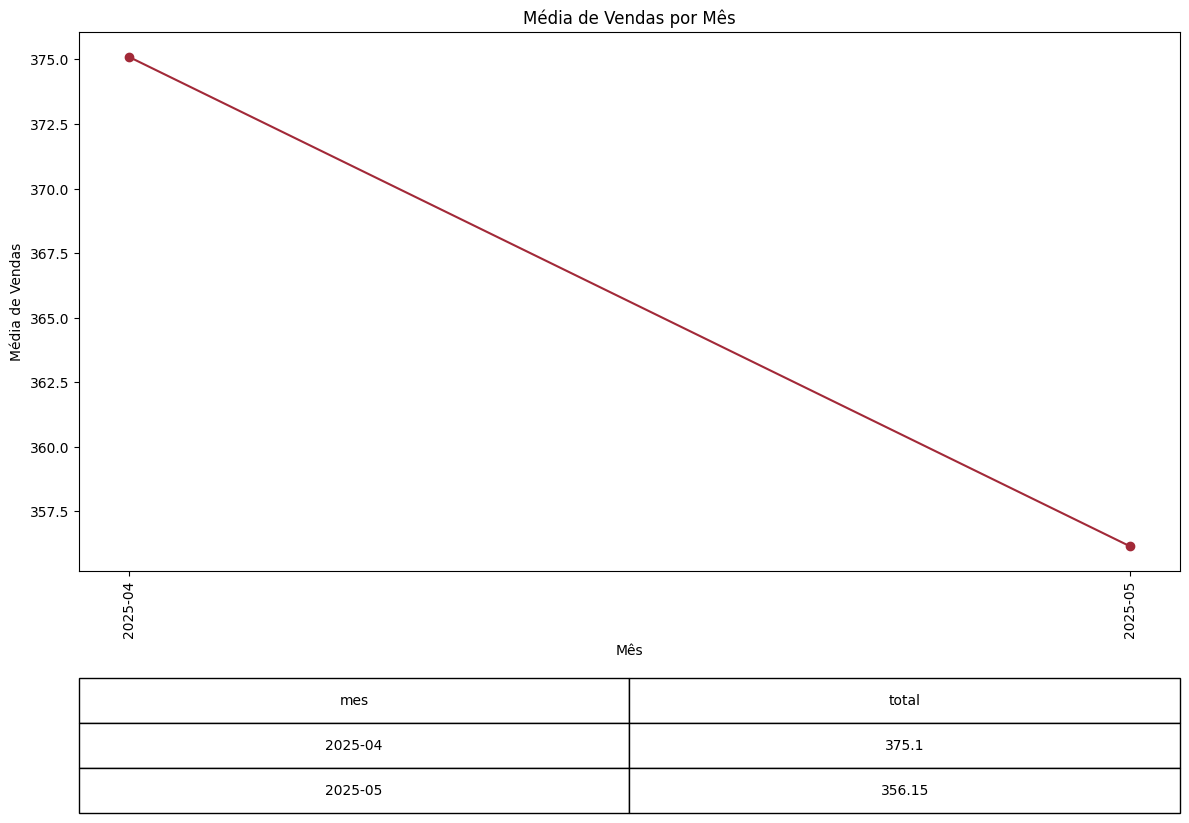

In [12]:
# Garantir que a data está no formato correto e extrair mês
df_filtrado['data'] = pd.to_datetime(df_filtrado['data'], dayfirst=True, errors='coerce')
df_filtrado['mes'] = df_filtrado['data'].dt.to_period('M').astype(str)

# Calcular média de vendas por mês
df_mes = df_filtrado.groupby('mes')['total'].mean().reset_index()

# Selecionar os 10 meses mais recentes para exibir na tabela
tabela_dados = df_mes.tail(5).copy()
tabela_dados['total'] = tabela_dados['total'].round(2)

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar gráfico de linha
ax.plot(df_mes['mes'], df_mes['total'], marker='o', color=util.barra_vermelha)
ax.set_title('Média de Vendas por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Média de Vendas')
plt.xticks(rotation=90)

# Adicionar tabela abaixo do gráfico
tabela = plt.table(cellText=tabela_dados.values,
                   colLabels=tabela_dados.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.45, 1.0, 0.25])  # ajuste de posição conforme necessário

# Ajustar layout para não sobrepor
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()


### Análise percentual de participação das fazendas no total vendido

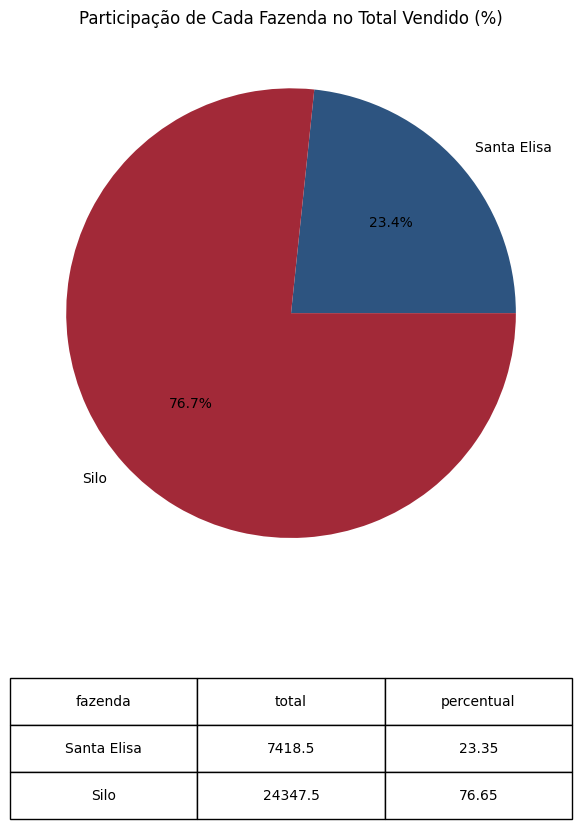

In [13]:
# Calcular total e percentual por fazenda
df_total_faz = df_filtrado.groupby('fazenda')['total'].sum().reset_index()
df_total_faz['percentual'] = df_total_faz['total'] / df_total_faz['total'].sum() * 100
df_total_faz['percentual'] = df_total_faz['percentual'].round(2)
df_total_faz['total'] = df_total_faz['total'].round(2)

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(10, 8))

# Gráfico de pizza
ax.pie(df_total_faz['percentual'],
       labels=df_total_faz['fazenda'],
       autopct='%1.1f%%',
       colors=[util.barra_azul, util.barra_vermelha])
ax.set_title('Participação de Cada Fazenda no Total Vendido (%)')

# Adicionar tabela abaixo do gráfico
tabela_dados = df_total_faz[['fazenda', 'total', 'percentual']]
tabela = plt.table(cellText=tabela_dados.values,
                   colLabels=tabela_dados.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.4, 1.0, 0.25])  # ajuste de posição conforme necessário

# Ajustar layout
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()


### Correlação entre quantidade e valor total das refeições

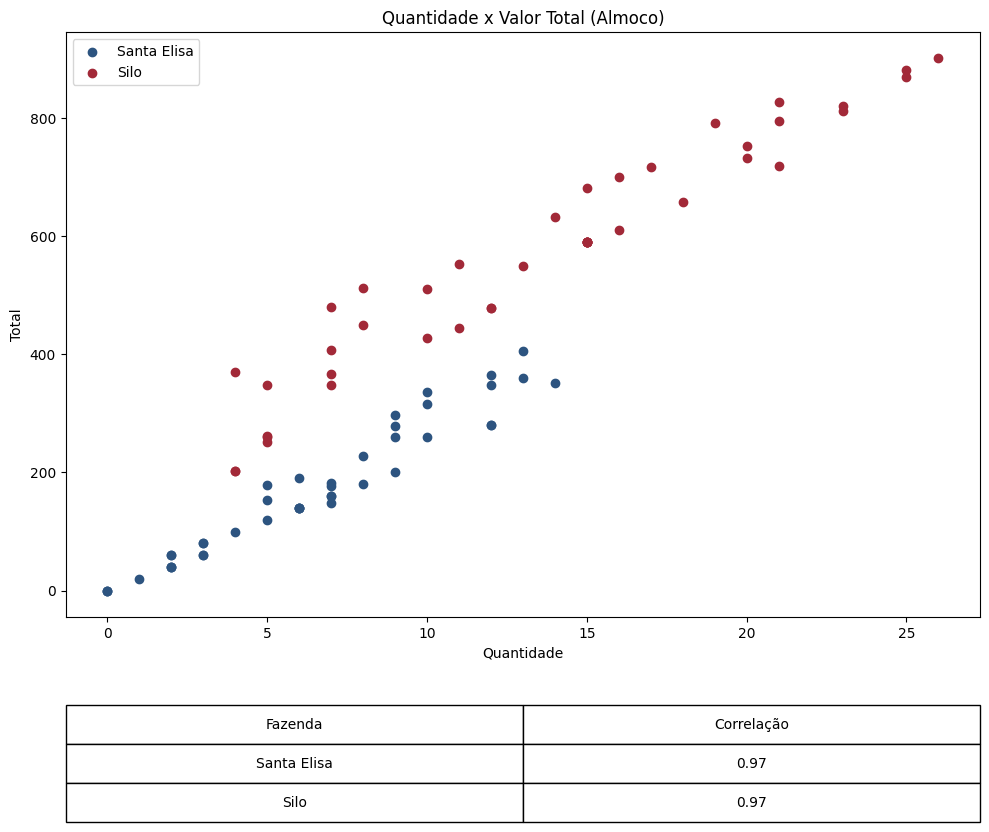

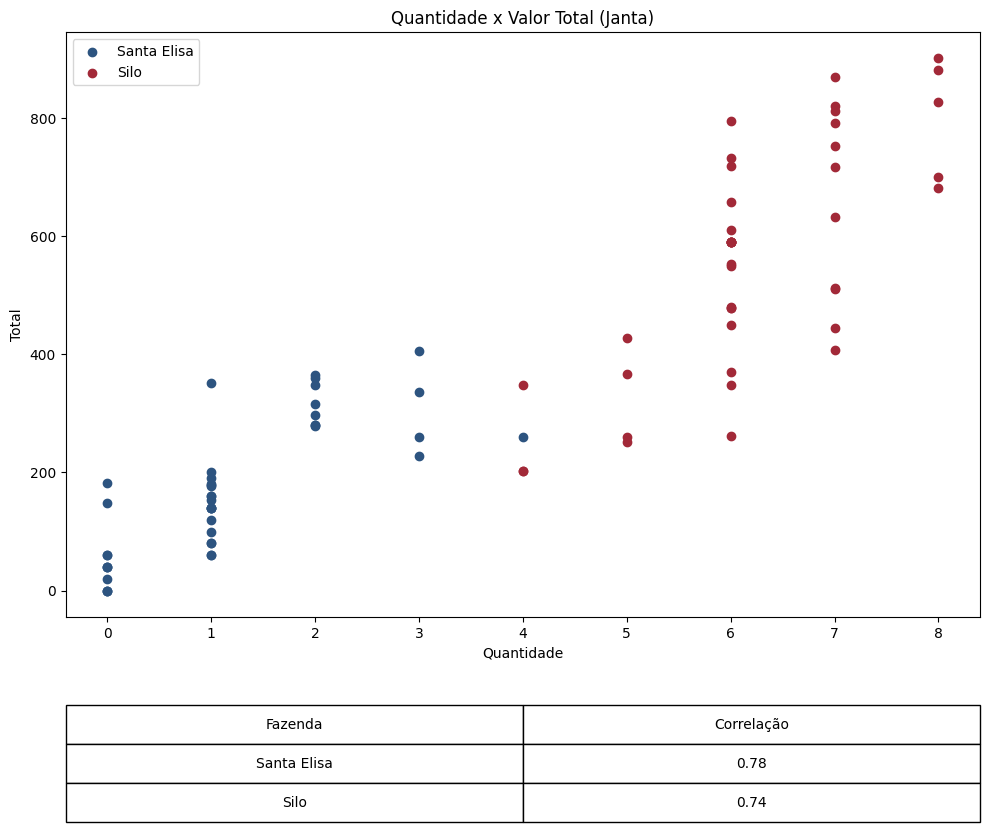

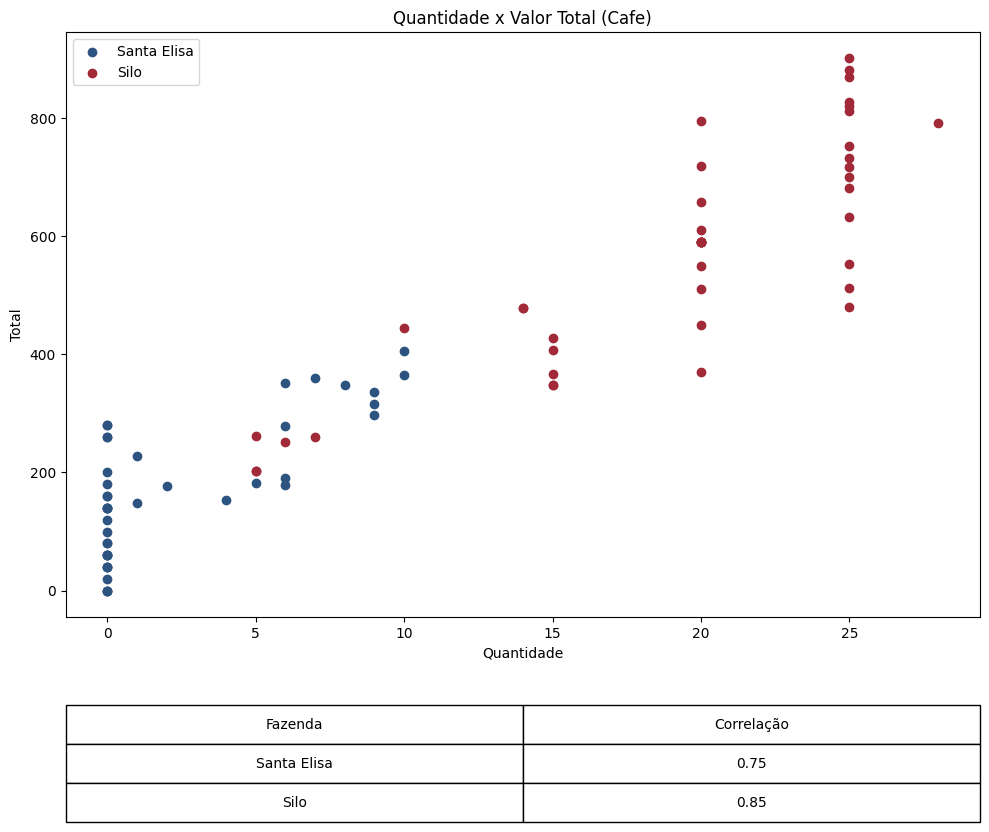

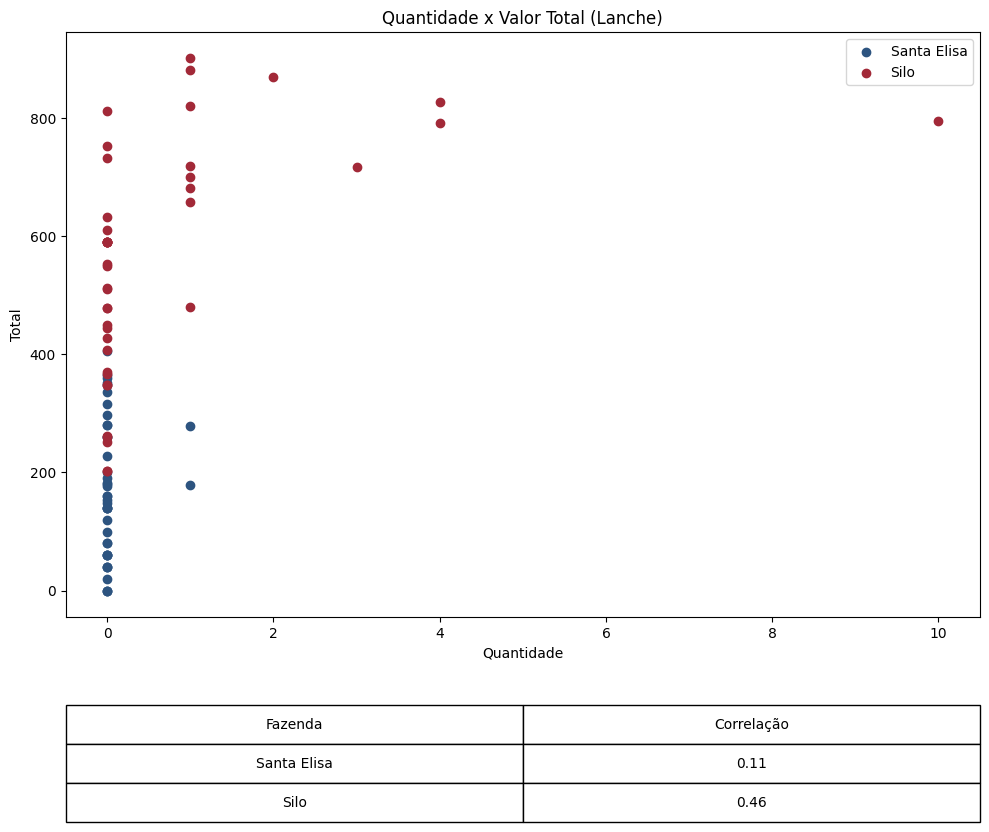

In [14]:
# Loop por tipo de refeição
for refeicao in ['almoco', 'janta', 'cafe', 'lanche']:
    plt.figure(figsize=(10, 8))
    correlacoes = []

    for i, faz in enumerate(df_filtrado['fazenda'].unique()):
        subset = df_filtrado[df_filtrado['fazenda'] == faz]

        # Gráfico de dispersão
        plt.scatter(subset[refeicao], subset['total'],
                    label=faz,
                    color=[util.barra_azul, util.barra_vermelha][i % 2])

        # Calcular correlação
        corr = subset[[refeicao, 'total']].corr().iloc[0, 1]
        correlacoes.append([faz, round(corr, 2)])

    plt.title(f'Quantidade x Valor Total ({refeicao.capitalize()})')
    plt.xlabel('Quantidade')
    plt.ylabel('Total')
    plt.legend()

    # Adicionar tabela com correlações
    tabela = plt.table(cellText=correlacoes,
                       colLabels=['Fazenda', 'Correlação'],
                       cellLoc='center',
                       loc='bottom',
                       bbox=[0.0, -0.35, 1.0, 0.2])  # ajustar conforme necessário

    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

### Evolução de cada tipo de refeição ao longo do tempo

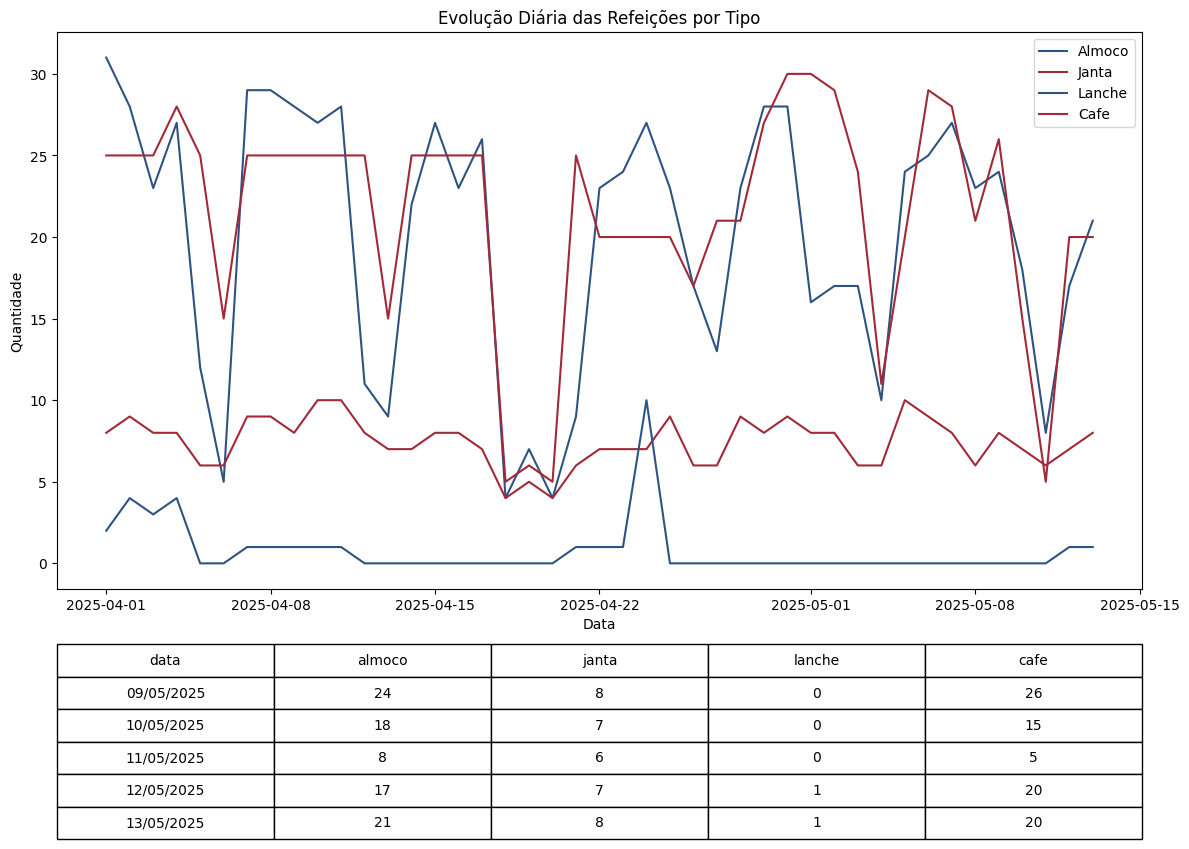

In [15]:
# Agrupar dados por data e somar as quantidades de refeições
df_refeicoes_tempo = df_filtrado.groupby('data')[qtd_cols].sum().reset_index()

# Selecionar os 10 dias mais recentes para a tabela
tabela_dados = df_refeicoes_tempo.tail(5).copy()
tabela_dados['data'] = pd.to_datetime(tabela_dados['data']).dt.strftime('%d/%m/%Y')
tabela_dados[qtd_cols] = tabela_dados[qtd_cols].astype(int)

# Criar figura
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar linhas para cada tipo de refeição
for i, col in enumerate(qtd_cols):
    ax.plot(df_refeicoes_tempo['data'], df_refeicoes_tempo[col],
            label=col.capitalize(), color=[util.barra_azul, util.barra_vermelha][i % 2])

ax.set_title('Evolução Diária das Refeições por Tipo')
ax.set_xlabel('Data')
ax.set_ylabel('Quantidade')
plt.xticks(rotation=0)
ax.legend()

# Adicionar tabela com os últimos 10 dias
tabela = plt.table(cellText=tabela_dados.values,
                   colLabels=tabela_dados.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.45, 1.0, 0.35])  # ajustar conforme necessário

# Ajustar layout para caber a tabela
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


### Receita média por tipo de refeição

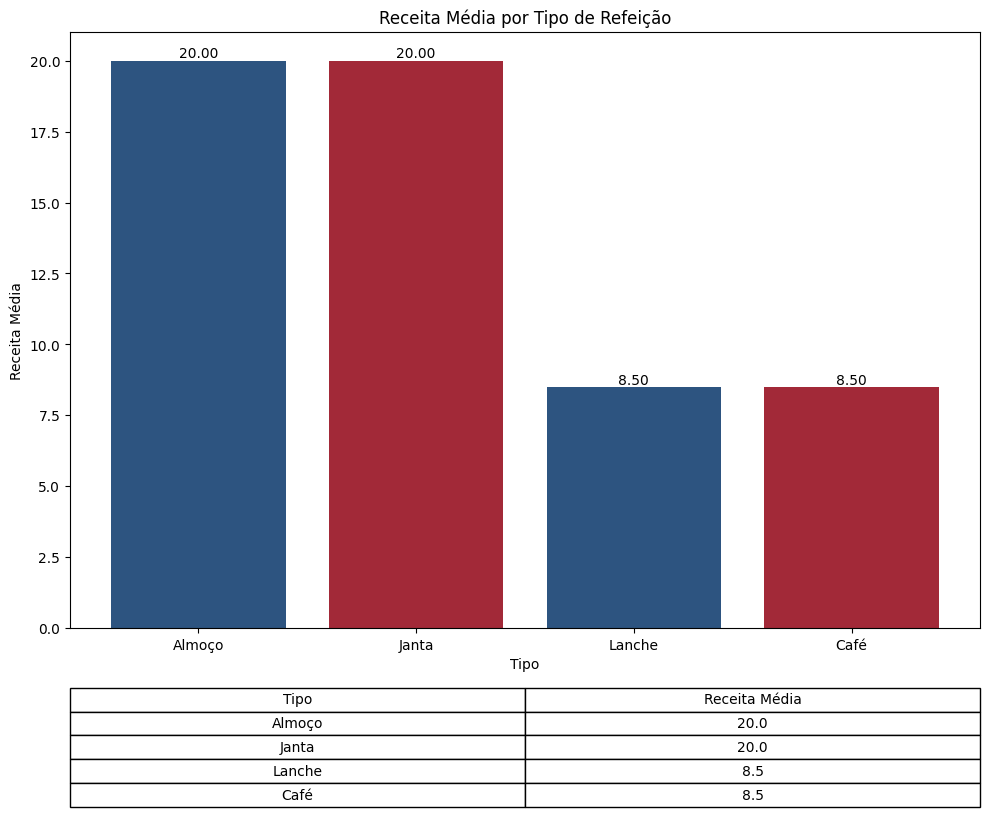

In [16]:
# Criar dataframe com receita média por tipo
df_receita_media = pd.DataFrame({
    'Tipo': ['Almoço', 'Janta', 'Lanche', 'Café'],
    'Receita Média': [
        df_filtrado['vlralmoco'].mean(),
        df_filtrado['vlrjanta'].mean(),
        df_filtrado['vlrlanche'].mean(),
        df_filtrado['vlrcafe'].mean()
    ]
})
df_receita_media['Receita Média'] = df_receita_media['Receita Média'].round(2)

# Criar figura
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar gráfico de barras
bars = ax.bar(df_receita_media['Tipo'], df_receita_media['Receita Média'],
              color=[util.barra_azul, util.barra_vermelha] * 2)

# Adicionar rótulos nas barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
            ha='center', va='bottom')

# Título e eixos
ax.set_title('Receita Média por Tipo de Refeição')
ax.set_xlabel('Tipo')
ax.set_ylabel('Receita Média')

# Adicionar tabela abaixo do gráfico
tabela = plt.table(cellText=df_receita_media.values,
                   colLabels=df_receita_media.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.3, 1.0, 0.2])  # ajustar conforme necessário

# Ajustar layout para acomodar a tabela
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()

### Análise de outliers no valor total por fazenda

/tmp/ipykernel_13105/1129517035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x='fazenda', y='total',


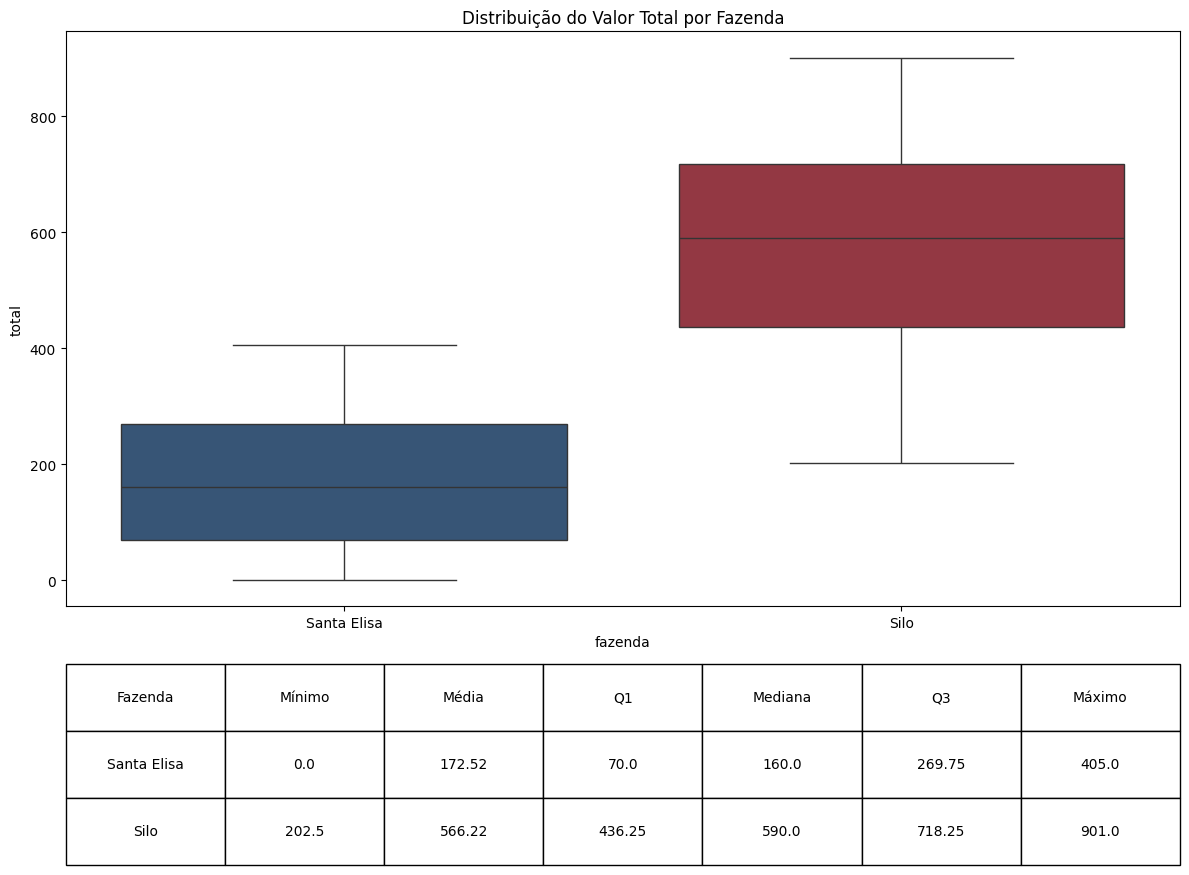

In [17]:
# Obter estatísticas descritivas completas por fazenda
desc = df_filtrado.groupby('fazenda')['total'].describe()

# Selecionar as colunas necessárias
df_stats = desc[['min', 'mean', '25%', '50%', '75%', 'max']].reset_index()

# Renomear colunas
df_stats.columns = ['Fazenda', 'Mínimo', 'Média', 'Q1', 'Mediana', 'Q3', 'Máximo']

# Arredondar
df_stats = df_stats.round(2)

# Plotar gráfico
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_filtrado, x='fazenda', y='total',
            palette=[util.barra_azul, util.barra_vermelha], ax=ax)
ax.set_title('Distribuição do Valor Total por Fazenda')

# Adicionar tabela abaixo do gráfico
tabela = plt.table(cellText=df_stats.values,
                   colLabels=df_stats.columns,
                   cellLoc='center',
                   loc='bottom',
                   bbox=[0.0, -0.45, 1.0, 0.35])

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()


### Proporção de cada tipo de refeição no total servido

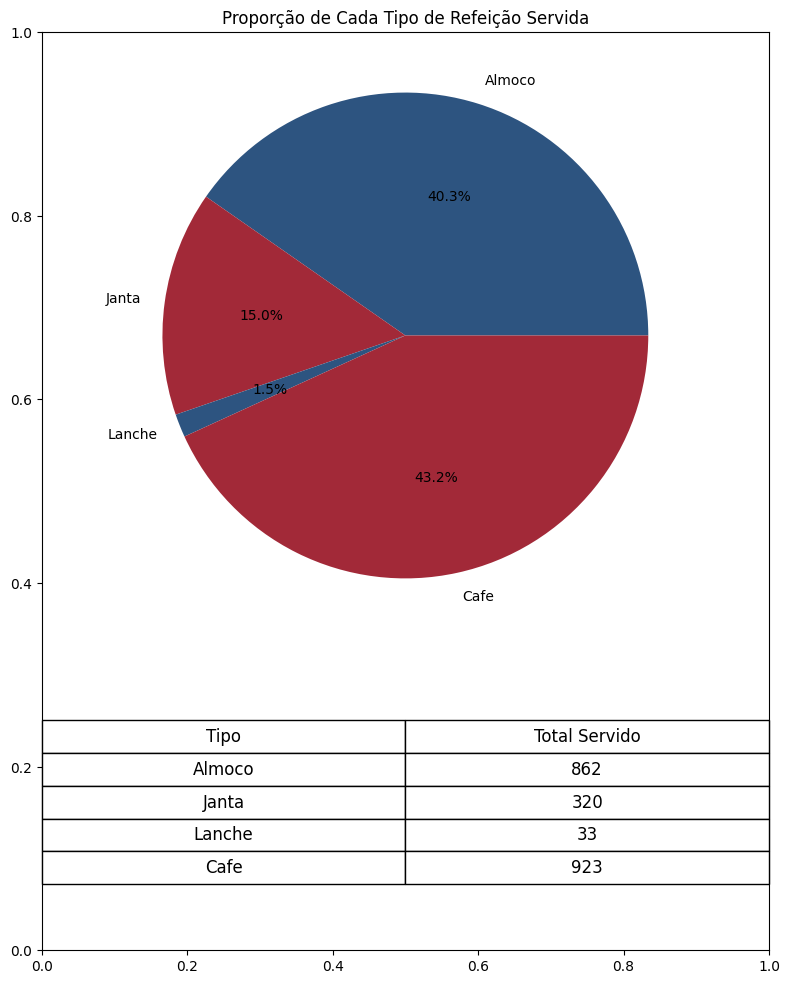

In [18]:

# Preparar os dados (já feitos)
df_total_refeicoes = df_filtrado[qtd_cols].sum().reset_index()
df_total_refeicoes.columns = ['Tipo', 'Total Servido']
df_total_refeicoes['Tipo'] = df_total_refeicoes['Tipo'].str.capitalize()

# Criar figura com espaço para gráfico e tabela
fig, ax = plt.subplots(figsize=(8, 10))

# Gráfico de pizza no eixo superior
ax_pie = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax_pie.pie(df_total_refeicoes['Total Servido'], labels=df_total_refeicoes['Tipo'],
           autopct='%1.1f%%', colors=[util.barra_azul, util.barra_vermelha]*2)
ax_pie.set_title('Proporção de Cada Tipo de Refeição Servida')

# Tabela abaixo
ax_table = plt.subplot2grid((3,1), (2,0))
ax_table.axis('off')  # esconder eixos

# Criar tabela
table = ax_table.table(cellText=df_total_refeicoes.values,
                       colLabels=df_total_refeicoes.columns,
                       cellLoc='center',
                       loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

### Média diária de refeições por fazenda

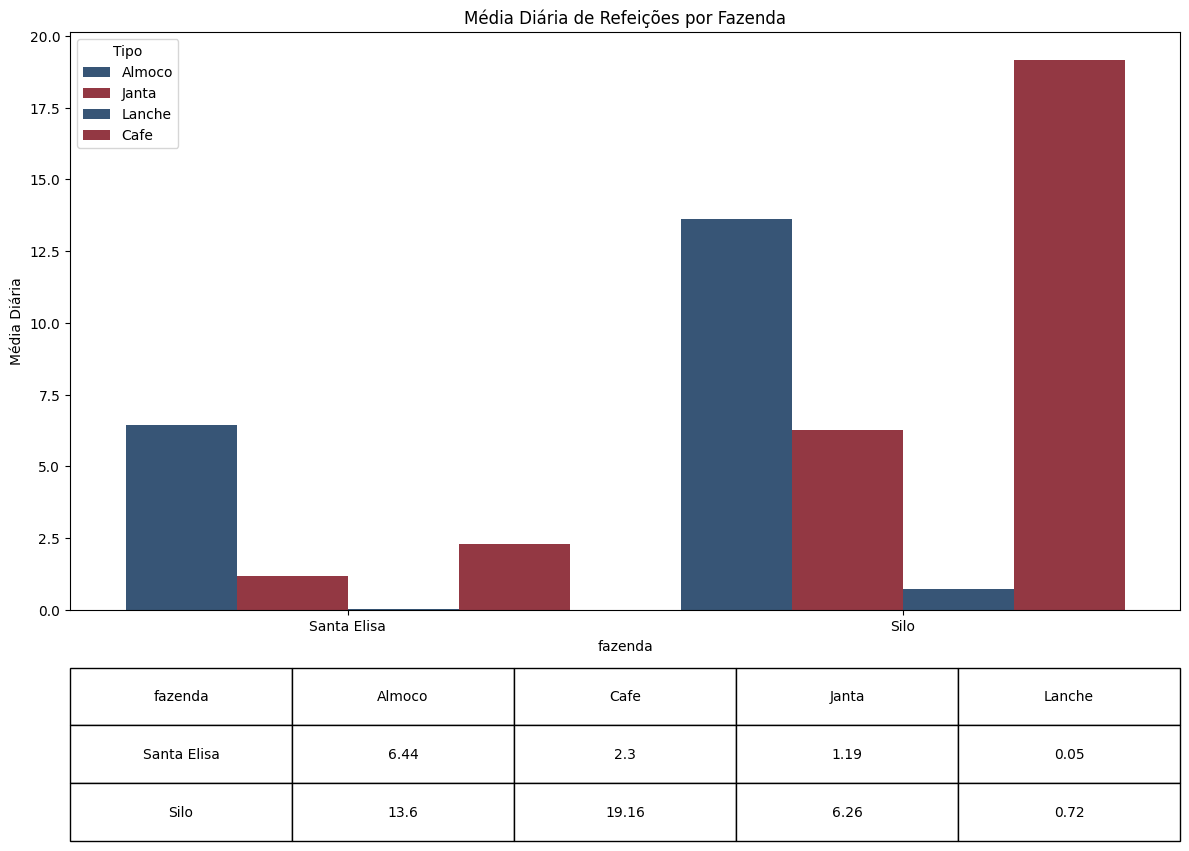

In [19]:
qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']

df_media_diaria = df_filtrado.groupby('fazenda')[qtd_cols].mean().reset_index()
df_media_diaria = df_media_diaria.melt(id_vars='fazenda', var_name='Tipo', value_name='Média Diária')
df_media_diaria['Tipo'] = df_media_diaria['Tipo'].str.capitalize()
df_tabela = df_media_diaria.pivot(index='fazenda', columns='Tipo', values='Média Diária').reset_index()
df_tabela = df_tabela.round(2)

# Criar figura maior para acomodar gráfico e tabela
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar gráfico de barras
sns.barplot(data=df_media_diaria, x='fazenda', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2, ax=ax)
ax.set_title('Média Diária de Refeições por Fazenda')

# Criar a tabela abaixo do gráfico
table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.4, 1, 0.3])  # ajustar posição e tamanho

# Ajustar espaço para caber a tabela
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


### Evolução do ticket médio diário por fazenda

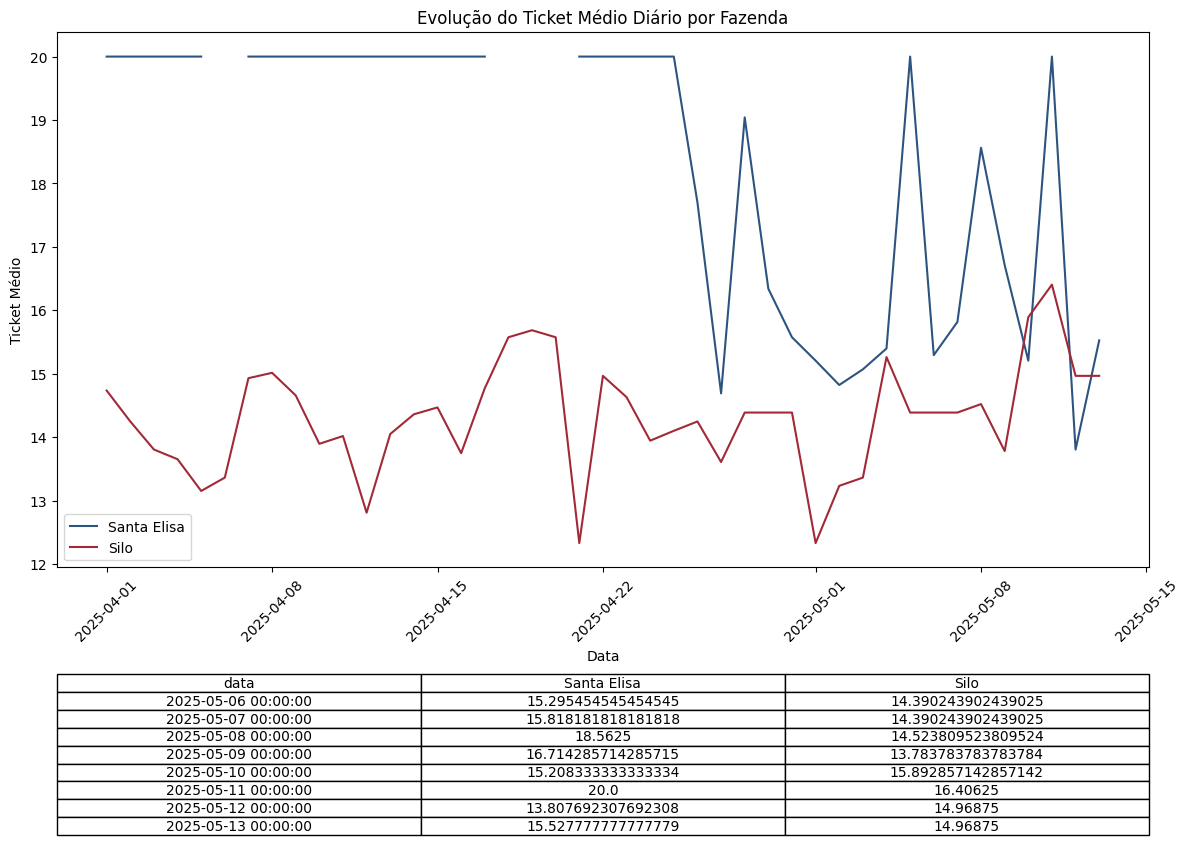

In [20]:
# Calcular o ticket médio diário por fazenda (já feito)
df_filtrado['ticket_medio'] = df_filtrado['total'] / df_filtrado[qtd_cols].sum(axis=1).replace(0, pd.NA)
df_ticket_diario = df_filtrado.groupby(['data', 'fazenda'])['ticket_medio'].mean().reset_index()

# Preparar dados para a tabela: últimos 10 dias por fazenda, pivoteado para legibilidade
df_tabela = df_ticket_diario[df_ticket_diario['data'] >= df_ticket_diario['data'].max() - pd.Timedelta(days=7)]
df_tabela_pivot = df_tabela.pivot(index='data', columns='fazenda', values='ticket_medio').round(2).reset_index()

# Plot gráfico
fig, ax = plt.subplots(figsize=(12, 8))

for i, faz in enumerate(df_ticket_diario['fazenda'].unique()):
    subset = df_ticket_diario[df_ticket_diario['fazenda'] == faz]
    ax.plot(subset['data'], subset['ticket_medio'], label=faz,
            color=[util.barra_azul, util.barra_vermelha][i % 2])

ax.set_title('Evolução do Ticket Médio Diário por Fazenda')
ax.set_xlabel('Data')
ax.set_ylabel('Ticket Médio')
ax.legend()
plt.xticks(rotation=45)

# Adicionar tabela abaixo do gráfico
table = plt.table(cellText=df_tabela_pivot.values,
                  colLabels=df_tabela_pivot.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.5, 1, 0.3])  # Ajuste posição e tamanho

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Top 5 datas com maior venda total

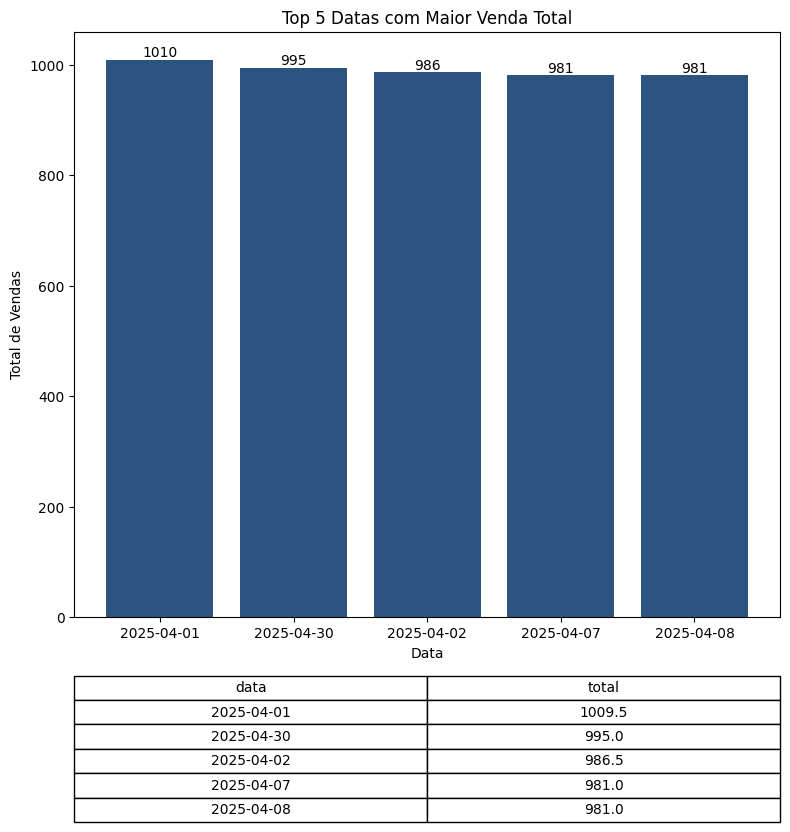

In [ ]:
# Dados já prontos
df_top_vendas = df_filtrado.groupby('data')['total'].sum().nlargest(5).reset_index()
df_top_vendas['data'] = df_top_vendas['data'].astype(str)  # para exibir no gráfico e tabela

# Criar figura com espaço para gráfico e tabela
fig, ax = plt.subplots(figsize=(8, 8))

# Plotar gráfico de barras
bars = ax.bar(df_top_vendas['data'], df_top_vendas['total'], color=util.barra_azul)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
            ha='center', va='bottom')

ax.set_title('Top 5 Datas com Maior Venda Total')
ax.set_xlabel('Data')
ax.set_ylabel('Total de Vendas')
plt.xticks(rotation=0)

# Adicionar tabela abaixo do gráfico
table = plt.table(cellText=df_top_vendas.values,
                  colLabels=df_top_vendas.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.35, 1, 0.25])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()


### Top 5 dias com maior venda total por fazenda

In [22]:
# Lista para guardar os top 5 por fazenda
lista_top5 = []

for fazenda in df['fazenda'].unique():
    top5 = df[df['fazenda'] == fazenda].sort_values('total', ascending=False).head(5)
    top5 = top5[['fazenda', 'data', 'total']]
    lista_top5.append(top5)

# Concatenar todas as tabelas em uma só
df_top5_fazendas = pd.concat(lista_top5).reset_index(drop=True)

# Mostrar tabela
print(df_top5_fazendas)


       fazenda       data    total
0  Santa Elisa 2021-05-04  11236.0
1  Santa Elisa 2021-07-07  10803.5
2  Santa Elisa 2021-05-05  10725.5
3  Santa Elisa 2021-06-29  10723.0
4  Santa Elisa 2021-07-09  10697.0
5         Silo 2023-09-19   5872.0
6         Silo 2023-09-20   5840.5
7         Silo 2023-09-18   5369.0
8         Silo 2023-09-16   5314.5
9         Silo 2023-09-14   5148.0


### Dias da semana com maior venda média

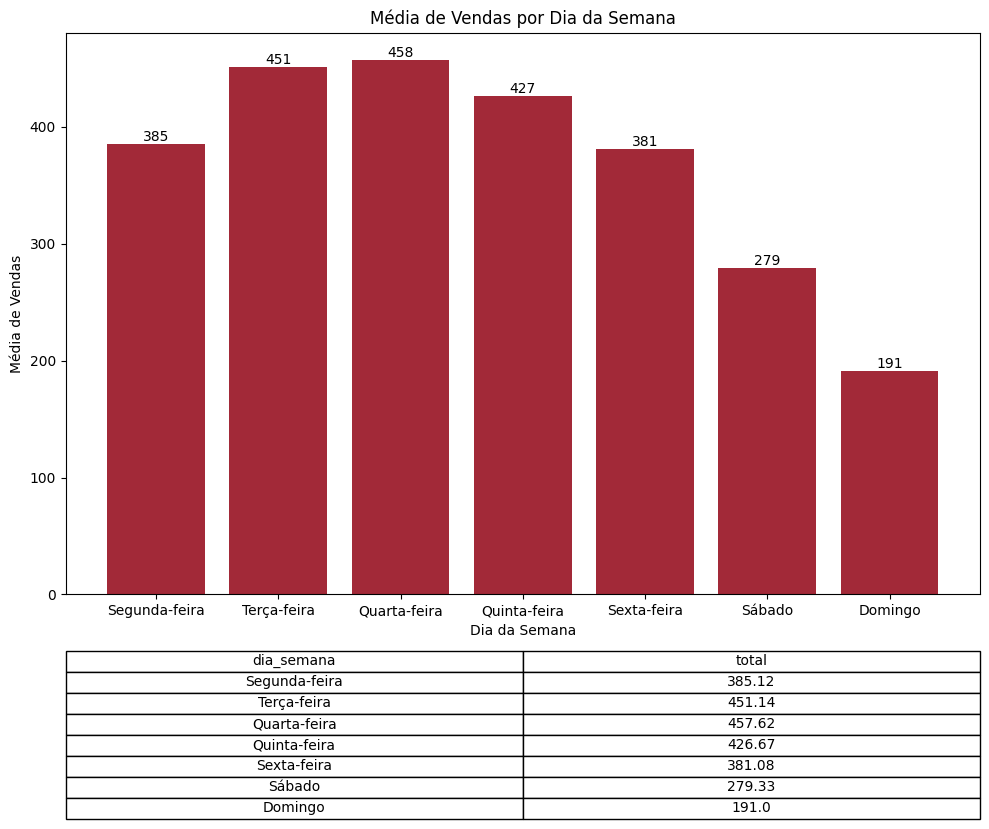

In [23]:

df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_venda_dia = df_filtrado.groupby('dia_semana')['total'].mean().reset_index()
df_venda_dia['dia_semana'] = df_venda_dia['dia_semana'].map(util.traducao_dias)

ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_venda_dia['dia_semana'] = pd.Categorical(df_venda_dia['dia_semana'], categories=ordem_dias_pt, ordered=True)
df_venda_dia = df_venda_dia.sort_values('dia_semana')

fig, ax = plt.subplots(figsize=(10, 8))

# Gráfico de barras
bars = ax.bar(df_venda_dia['dia_semana'], df_venda_dia['total'], color=util.barra_vermelha)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
            ha='center', va='bottom')

ax.set_title('Média de Vendas por Dia da Semana')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Média de Vendas')
plt.xticks(rotation=0)

# Criar tabela abaixo do gráfico
# Ajuste bbox para colocar a tabela visível abaixo do gráfico
table = plt.table(cellText=df_venda_dia.round(2).values,
                  colLabels=df_venda_dia.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.4, 1, 0.3])  # posição e tamanho

plt.subplots_adjust(bottom=0.3)  # Ajustar espaço inferior para tabela
plt.tight_layout()
plt.show()

#### Média diária de quantidade refeições por dia da semana

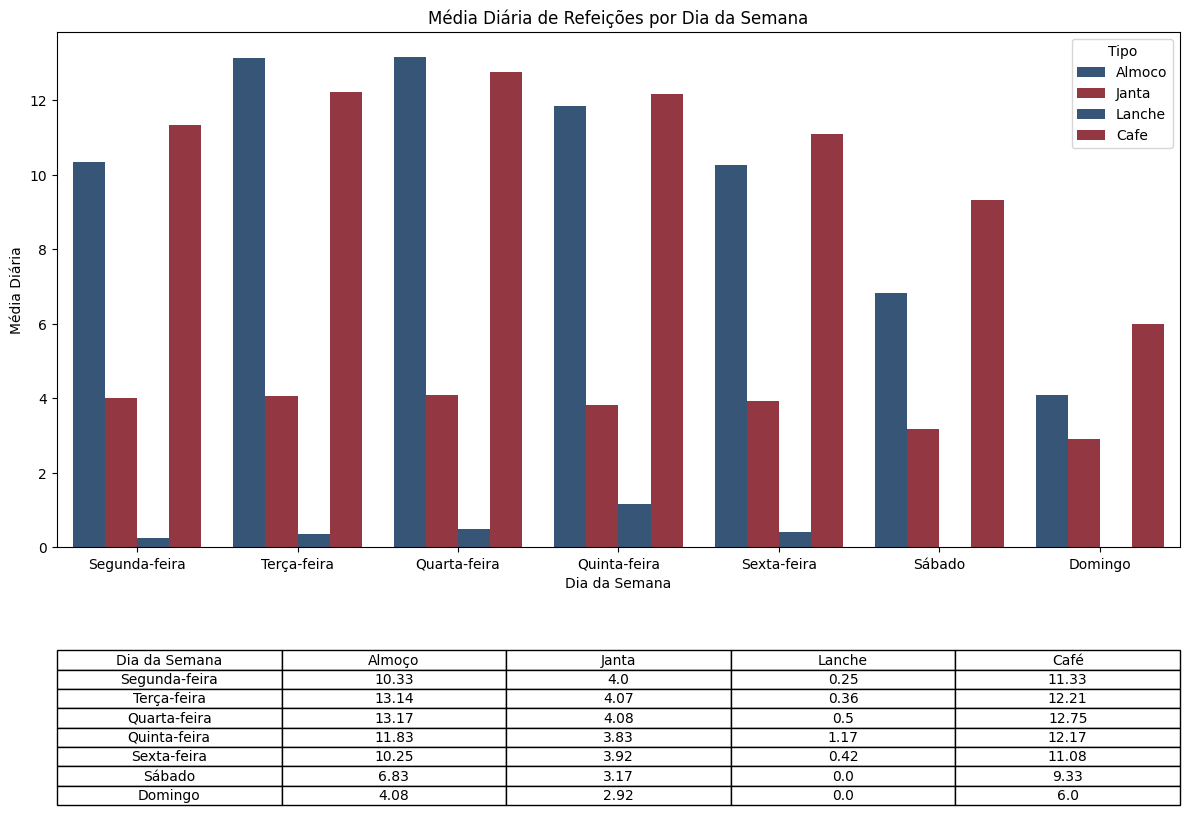

In [24]:

qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']

# Certifique-se que df_filtrado e util.traducao_dias já existem

# Criar coluna dia da semana traduzida e ordenar
df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_media_semana = df_filtrado.groupby('dia_semana')[qtd_cols].mean().reset_index()
df_media_semana['dia_semana'] = df_media_semana['dia_semana'].map(util.traducao_dias)

ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira',
                 'Sexta-feira', 'Sábado', 'Domingo']
df_media_semana['dia_semana'] = pd.Categorical(df_media_semana['dia_semana'],
                                              categories=ordem_dias_pt, ordered=True)
df_media_semana = df_media_semana.sort_values('dia_semana')

# Preparar dados para gráfico
df_melted = df_media_semana.melt(id_vars='dia_semana', var_name='Tipo', value_name='Média Diária')
df_melted['Tipo'] = df_melted['Tipo'].str.capitalize()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=df_melted, x='dia_semana', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2, ax=ax)
ax.set_title('Média Diária de Refeições por Dia da Semana')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Média Diária')
plt.xticks(rotation=0)

# Preparar tabela
df_tabela = df_media_semana.copy()
df_tabela.columns = ['Dia da Semana', 'Almoço', 'Janta', 'Lanche', 'Café']
df_tabela = df_tabela.round(2)

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

### Boxplot do valor total por fazenda

/tmp/ipykernel_13105/3983778348.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='fazenda', y='total', palette=[util.barra_azul, util.barra_vermelha], ax=ax)


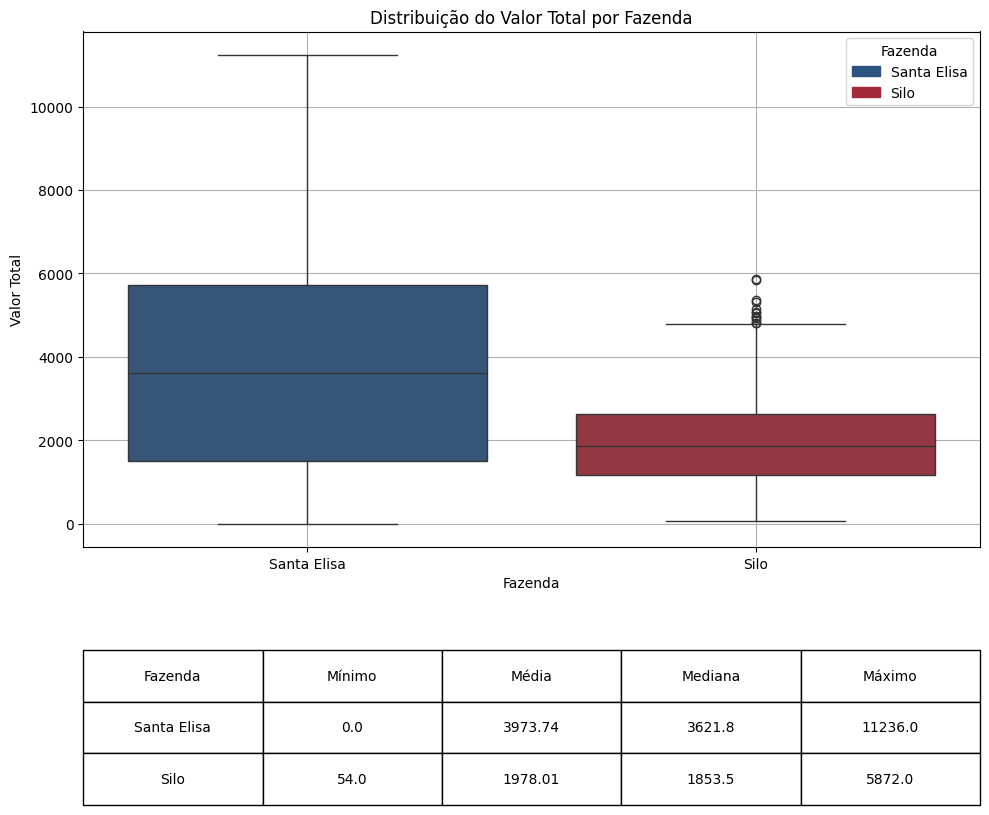

In [25]:
# 017. Boxplot do valor total por fazenda

import matplotlib.patches as mpatches

# Estatísticas descritivas por fazenda
df_stats = df.groupby('fazenda')['total'].agg(['min', 'mean', 'median', 'max']).reset_index()
df_stats.columns = ['Fazenda', 'Mínimo', 'Média', 'Mediana', 'Máximo']
df_stats = df_stats.round(2)

# Criar figura com espaço para gráfico e tabela
fig, ax = plt.subplots(figsize=(10, 8))

# Plot boxplot com cores customizadas usando seaborn
sns.boxplot(data=df, x='fazenda', y='total', palette=[util.barra_azul, util.barra_vermelha], ax=ax)

ax.set_title('Distribuição do Valor Total por Fazenda')
ax.set_xlabel('Fazenda')
ax.set_ylabel('Valor Total')
plt.xticks(rotation=0)
ax.grid(True)

# Legenda customizada
legend_patches = [mpatches.Patch(color=cor, label=fazenda) for cor, fazenda in zip([util.barra_azul, util.barra_vermelha], sorted(df['fazenda'].unique()))]
ax.legend(handles=legend_patches, title='Fazenda')

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_stats.values,
                  colLabels=df_stats.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()
plt.show()

### Série temporal do total de vendas

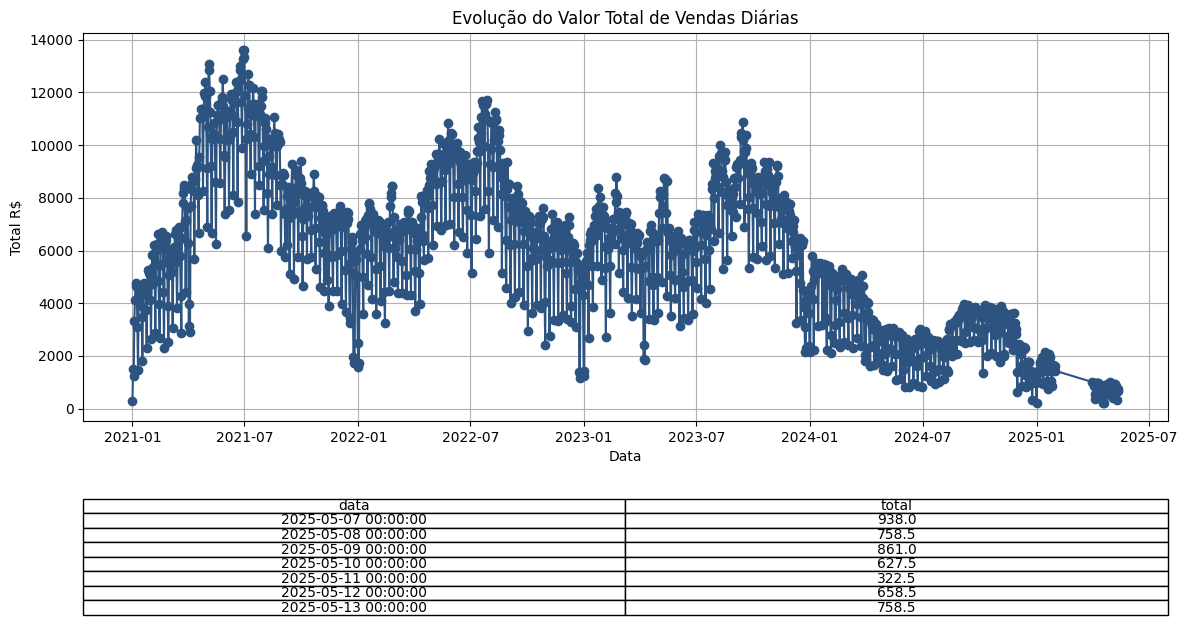

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

# Total de vendas por data - gráfico com todos os dados
df_grouped = df.groupby('data')['total'].sum().reset_index()

ax.plot(df_grouped['data'], df_grouped['total'], marker='o', linestyle='-', color=util.barra_azul)
ax.set_title('Evolução do Valor Total de Vendas Diárias')
ax.set_xlabel('Data')
ax.set_ylabel('Total R$')
ax.grid(True)
plt.xticks(rotation=0)

# Tabela mostrando só os últimos 10 dias
df_tabela = df_grouped.tail(7).round(2)

table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Comparativo entre tipos de refeição (quantidade total)

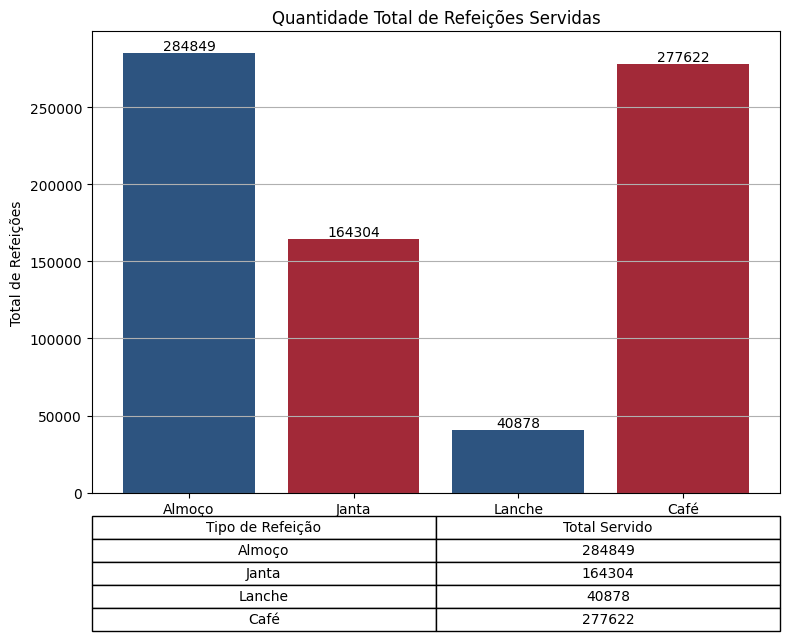

In [27]:
# 019. Comparativo entre tipos de refeição (quantidade total)
qtd_totais = df[['almoco', 'janta', 'lanche', 'cafe']].sum()
qtd_totais.index = ['Almoço', 'Janta', 'Lanche', 'Café']

fig, ax = plt.subplots(figsize=(8, 6))

cores = [util.barra_azul, util.barra_vermelha, util.barra_azul, util.barra_vermelha]
bars = ax.bar(qtd_totais.index, qtd_totais.values, color=cores)
ax.set_title('Quantidade Total de Refeições Servidas')
ax.set_ylabel('Total de Refeições')
ax.grid(axis='y')

# Valores sobre as barras
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
            ha='center', va='bottom')

# Criar tabela com os totais
table_data = qtd_totais.reset_index()
table_data.columns = ['Tipo de Refeição', 'Total Servido']

table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.3, 1, 0.25])  # ajustar posição da tabela

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()

### Ticket médio por fazenda

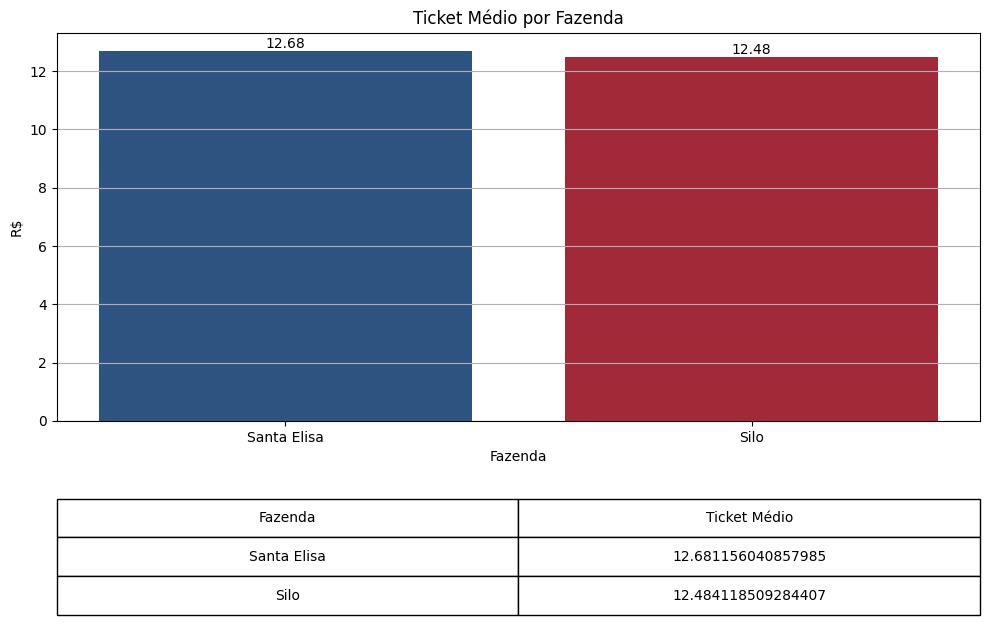

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

df['qtd_total'] = df[['almoco', 'janta', 'lanche', 'cafe']].sum(axis=1)
df['ticket_medio'] = df['total'] / df['qtd_total'].replace(0, pd.NA)

ticket_fazenda = df.groupby('fazenda')['ticket_medio'].mean()

cores = [util.barra_azul, util.barra_vermelha]
bars = ax.bar(ticket_fazenda.index, ticket_fazenda.values, color=cores)

ax.set_title('Ticket Médio por Fazenda')
ax.set_ylabel('R$')
ax.set_xlabel('Fazenda')
ax.grid(axis='y')
plt.xticks(rotation=0)

# Mostrar valores acima das barras
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom')

# Criar tabela logo abaixo do gráfico
df_tabela = ticket_fazenda.reset_index()
df_tabela.columns = ['Fazenda', 'Ticket Médio']
df_tabela['Ticket Médio'] = df_tabela['Ticket Médio'].round(2)

table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Calor do volume total de refeições por dia da semana e fazenda

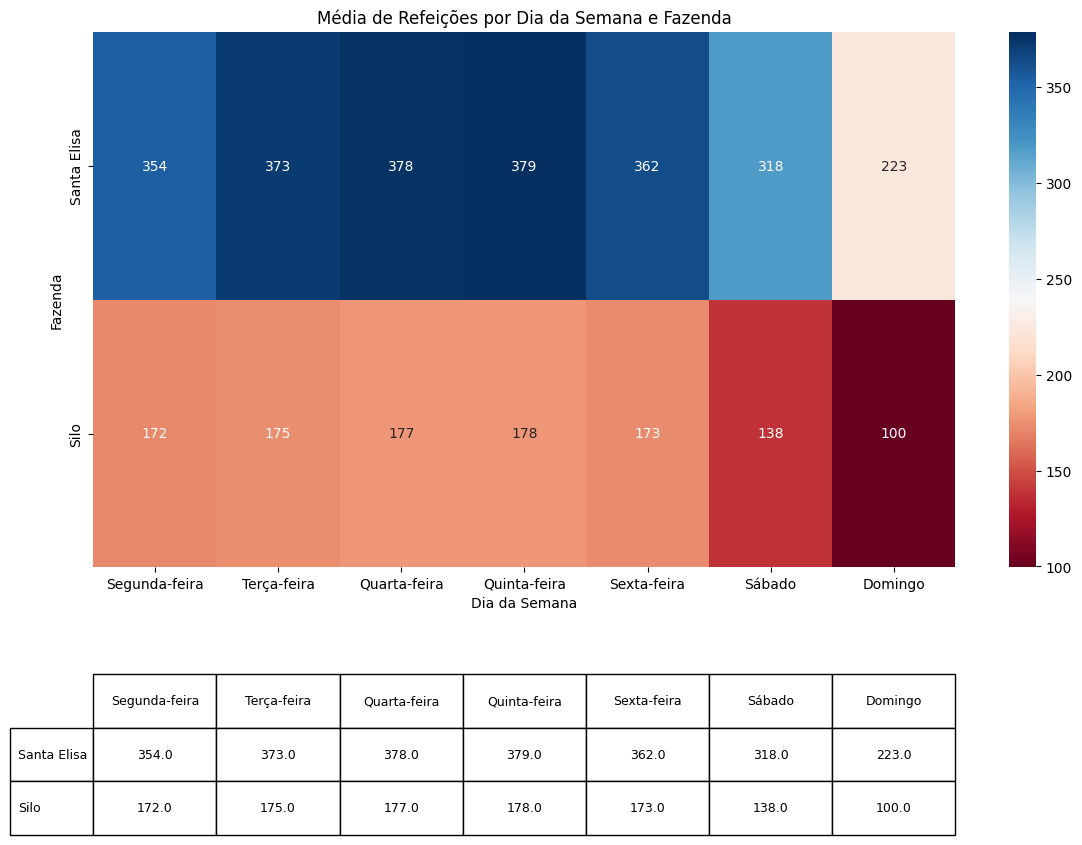

In [29]:
# 021. 
# Preparar dados
df['dia_semana'] = df['data'].dt.day_name()
df['dia_semana'] = df['dia_semana'].map({
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
})

pivot_table = df.pivot_table(index='fazenda', columns='dia_semana',
                              values='qtd_total', aggfunc='mean')

dias_ordenados_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
pivot_table = pivot_table[dias_ordenados_pt]

# Plotar heatmap + tabela
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='RdBu', ax=ax)
ax.set_title('Média de Refeições por Dia da Semana e Fazenda')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Fazenda')

table = plt.table(cellText=pivot_table.round(0).values,
                  colLabels=pivot_table.columns,
                  rowLabels=pivot_table.index,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


### Variação diária do total vendido por fazenda

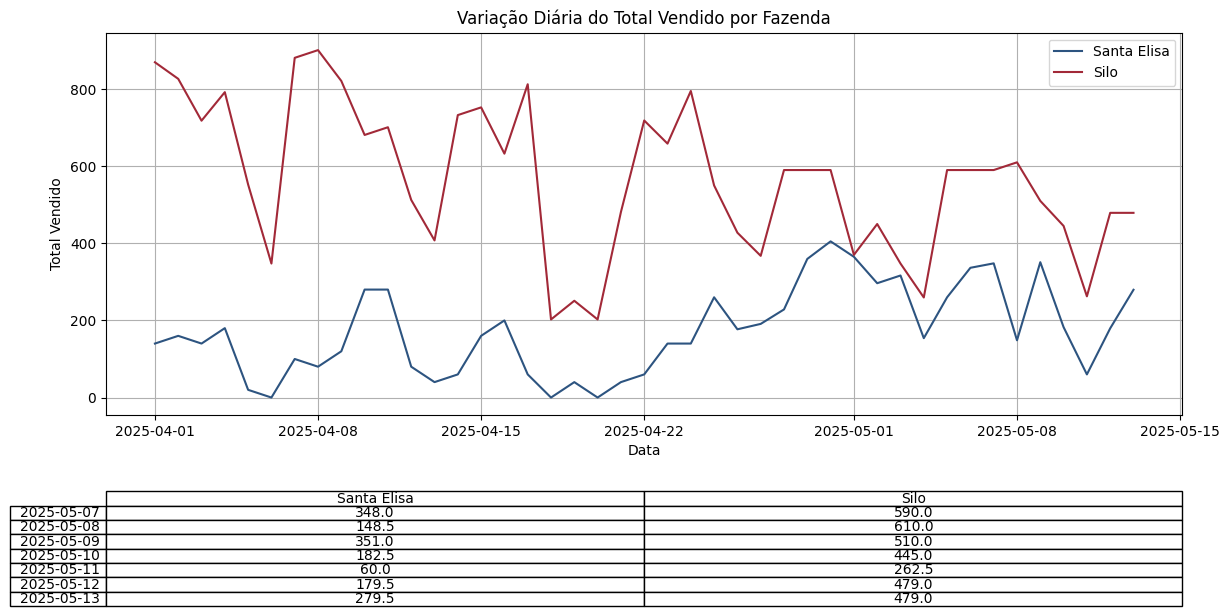

In [30]:
# 22. Variação diária do total vendido por fazenda
fig, ax = plt.subplots(figsize=(12, 6))

cores_personalizadas = [util.barra_azul, util.barra_vermelha]
fazendas = df_filtrado['fazenda'].unique()

for i, fazenda in enumerate(fazendas):
    dados_fazenda = df_filtrado[df_filtrado['fazenda'] == fazenda].groupby('data')['total'].sum()
    ax.plot(dados_fazenda.index, dados_fazenda.values, label=fazenda, color=cores_personalizadas[i % len(cores_personalizadas)])

ax.set_title('Variação Diária do Total Vendido por Fazenda')
ax.set_ylabel('Total Vendido')
ax.set_xlabel('Data')
ax.legend()
ax.grid(True)

plt.tight_layout()

# Criar tabela com os últimos 10 dias da soma total por fazenda
tabela_df = df_filtrado.groupby(['data', 'fazenda'])['total'].sum().unstack().fillna(0)
tabela_df = tabela_df.tail(7).round(2)

# Ajustar bbox para colocar a tabela abaixo do gráfico
table = plt.table(cellText=tabela_df.values,
                  colLabels=tabela_df.columns,
                  rowLabels=[d.strftime('%Y-%m-%d') for d in tabela_df.index],
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()

### Distribuição do ticket médio por fazenda

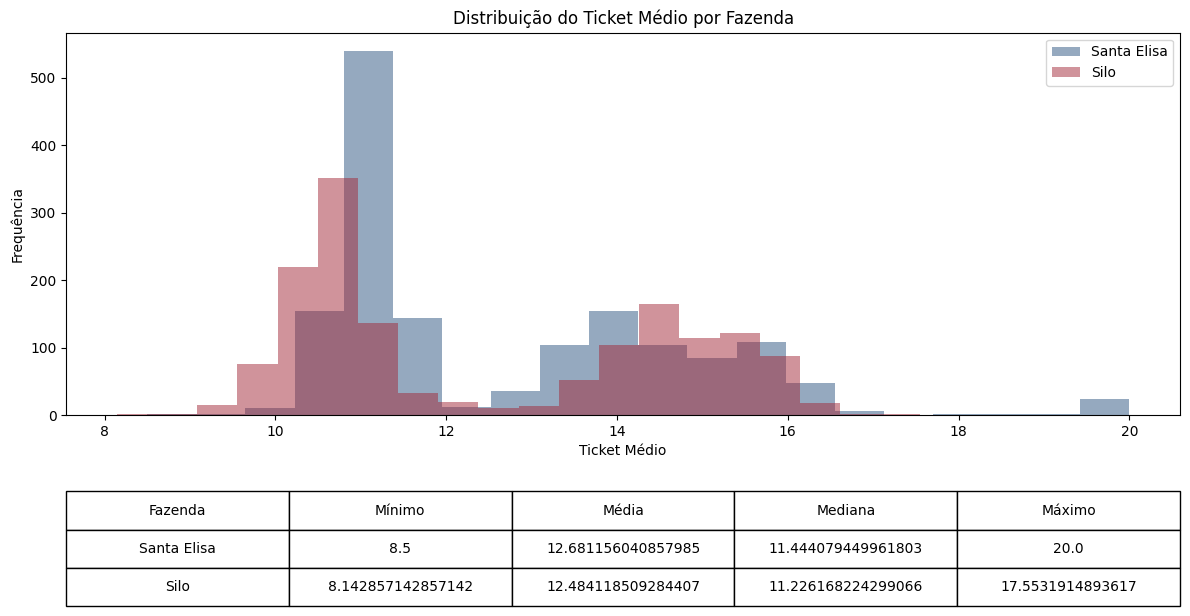

In [31]:
# 23. Distribuição do ticket médio por fazenda
fig, ax = plt.subplots(figsize=(12, 6))

cores_personalizadas = [util.barra_azul, util.barra_vermelha]
fazendas = df['fazenda'].unique()

for i, fazenda in enumerate(fazendas):
    dados_fazenda = df[df['fazenda'] == fazenda]['ticket_medio'].dropna()
    ax.hist(dados_fazenda, bins=20, alpha=0.5, label=fazenda, color=cores_personalizadas[i % len(cores_personalizadas)])

ax.set_title('Distribuição do Ticket Médio por Fazenda')
ax.set_xlabel('Ticket Médio')
ax.set_ylabel('Frequência')
ax.legend()
plt.tight_layout()

# Estatísticas descritivas do ticket médio por fazenda
df_stats = df.groupby('fazenda')['ticket_medio'].agg(['min', 'mean', 'median', 'max']).reset_index()
df_stats.columns = ['Fazenda', 'Mínimo', 'Média', 'Mediana', 'Máximo']
df_stats = df_stats.round(2)

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_stats.values,
                  colLabels=df_stats.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()

### # 24. Correlação entre quantidade total e valor total com tabela

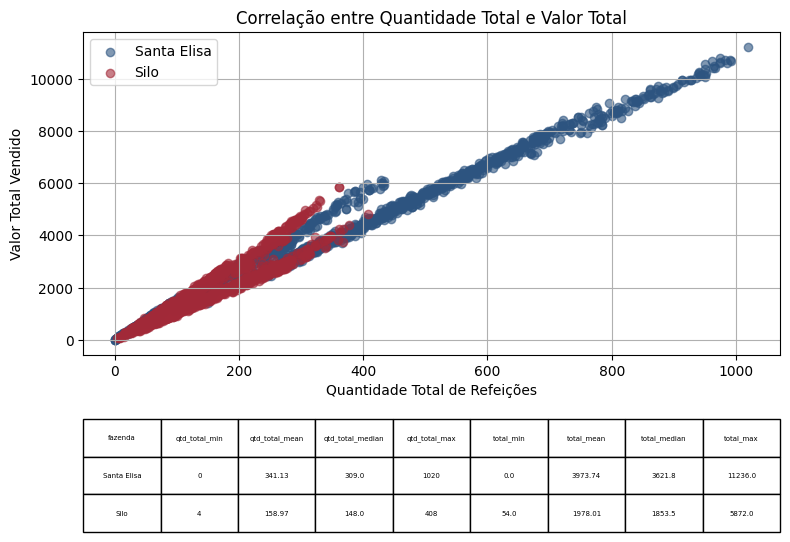

In [32]:


cores_personalizadas = [util.barra_azul, util.barra_vermelha]

fig, ax = plt.subplots(figsize=(8, 6))

for i, fazenda in enumerate(df['fazenda'].unique()):
    dados = df[df['fazenda'] == fazenda]
    ax.scatter(dados['qtd_total'], dados['total'], alpha=0.6, color=cores_personalizadas[i % 2], label=fazenda)

ax.set_title('Correlação entre Quantidade Total e Valor Total')
ax.set_xlabel('Quantidade Total de Refeições')
ax.set_ylabel('Valor Total Vendido')
ax.grid(True)
ax.legend()
plt.tight_layout()

# Estatísticas descritivas por fazenda para qtd_total e total
df_stats = df.groupby('fazenda')[['qtd_total', 'total']].agg(['min', 'mean', 'median', 'max']).round(2)
df_stats.columns = ['_'.join(col).strip() for col in df_stats.columns.values]
df_stats = df_stats.reset_index()

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_stats.values,
                  colLabels=df_stats.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.55, 1, 0.35])

plt.subplots_adjust(bottom=0.4)
plt.show()

###  Boxplot das quantidades por tipo de refeição

/tmp/ipykernel_13105/156437679.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot([df[col] for col in qtd_cols], labels=[c.capitalize() for c in qtd_cols], **boxprops)


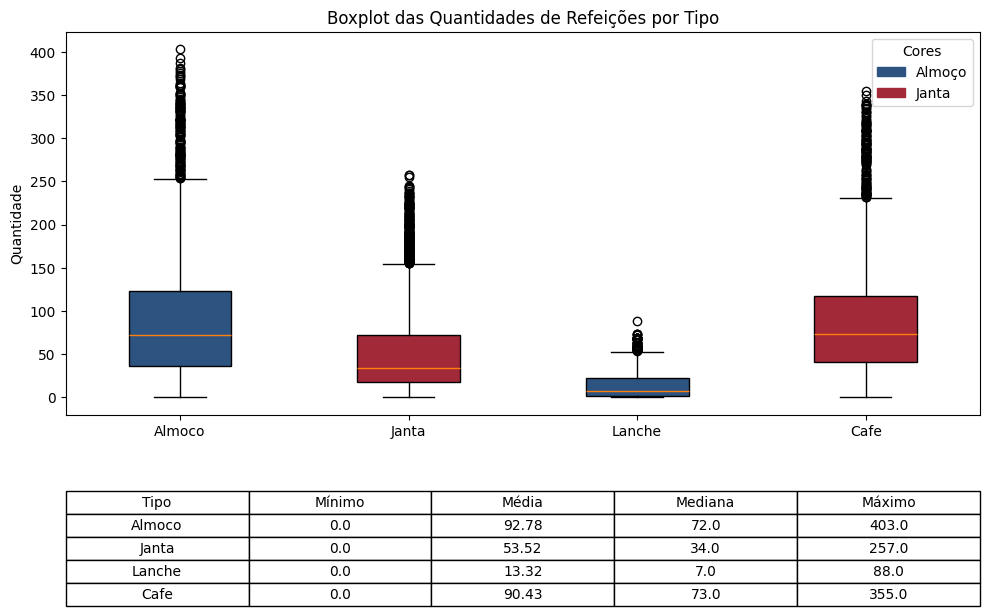

In [33]:
qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']

# Estatísticas descritivas por tipo de refeição
df_stats = df[qtd_cols].agg(['min', 'mean', 'median', 'max']).round(2).T.reset_index()
df_stats.columns = ['Tipo', 'Mínimo', 'Média', 'Mediana', 'Máximo']
df_stats['Tipo'] = df_stats['Tipo'].str.capitalize()

fig, ax = plt.subplots(figsize=(10, 6))

# Criar boxplot com patch_artist=True para personalizar cores
boxprops = dict(patch_artist=True)
boxplot = ax.boxplot([df[col] for col in qtd_cols], labels=[c.capitalize() for c in qtd_cols], **boxprops)

# Aplicar cores alternadas nas caixas
cores_personalizadas = [util.barra_azul, util.barra_vermelha]
for patch, color in zip(boxplot['boxes'], cores_personalizadas * 2):
    patch.set_facecolor(color)

ax.set_title('Boxplot das Quantidades de Refeições por Tipo')
ax.set_ylabel('Quantidade')
plt.tight_layout()

# Legenda customizada
legend_patches = [mpatches.Patch(color=cores_personalizadas[i], label=['Almoço', 'Janta'][i]) for i in range(2)]
ax.legend(handles=legend_patches, title='Cores')

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_stats.values,
                  colLabels=df_stats.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()

### Média diária de refeições por dia da semana

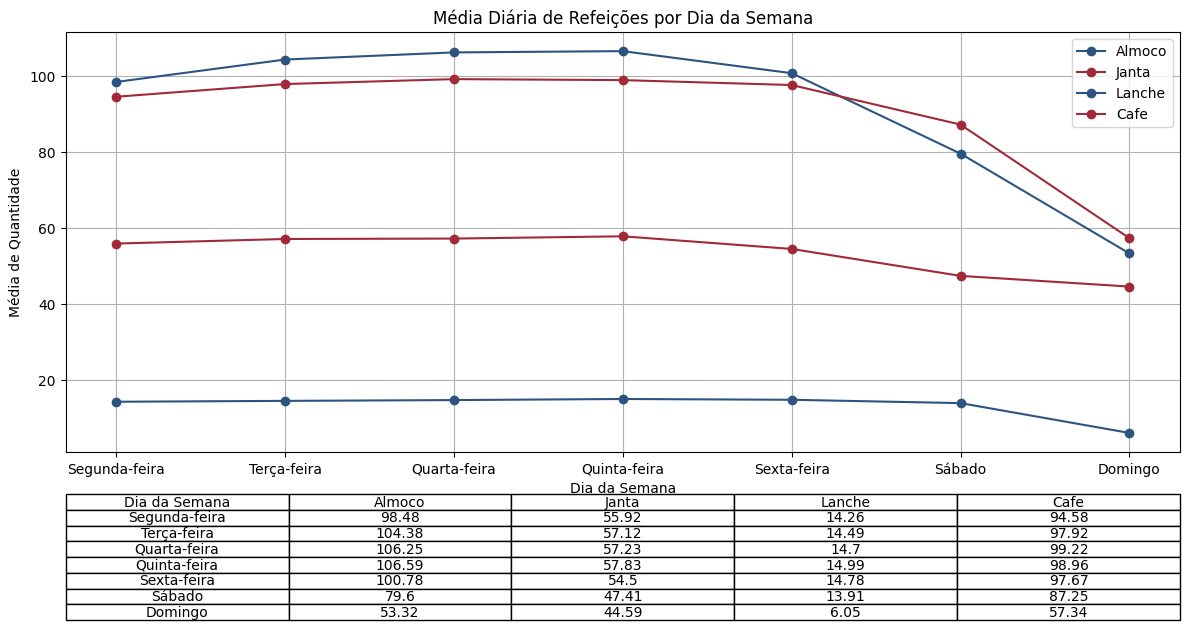

In [34]:
# Assegurar que 'dia_semana' está em inglês
df['dia_semana'] = df['data'].dt.day_name()

# Definir ordem dos dias em inglês para reindexar corretamente
dias_ingles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_port = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

# Agrupar e calcular média, reindexar na ordem correta
media_semana = df.groupby('dia_semana')[qtd_cols].mean().reindex(dias_ingles).reset_index()

# Mapear para português para exibir no gráfico e tabela
media_semana['dia_semana_pt'] = media_semana['dia_semana'].map(dict(zip(dias_ingles, dias_port)))

fig, ax = plt.subplots(figsize=(12, 6))

cores_personalizadas = [util.barra_azul, util.barra_vermelha]
for i, col in enumerate(qtd_cols):
    ax.plot(media_semana['dia_semana_pt'], media_semana[col], marker='o',
            label=col.capitalize(), color=cores_personalizadas[i % 2])

ax.set_title('Média Diária de Refeições por Dia da Semana')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Média de Quantidade')
ax.legend()
ax.grid(True)

# Preparar tabela para exibir com os nomes em português
df_stats = media_semana[['dia_semana_pt'] + qtd_cols].copy()
df_stats[qtd_cols] = df_stats[qtd_cols].round(2)
df_stats.columns = ['Dia da Semana'] + [c.capitalize() for c in qtd_cols]

table = plt.table(cellText=df_stats.values,
                  colLabels=df_stats.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.4, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

#### # 1. Média mensal de vendas e quantidade


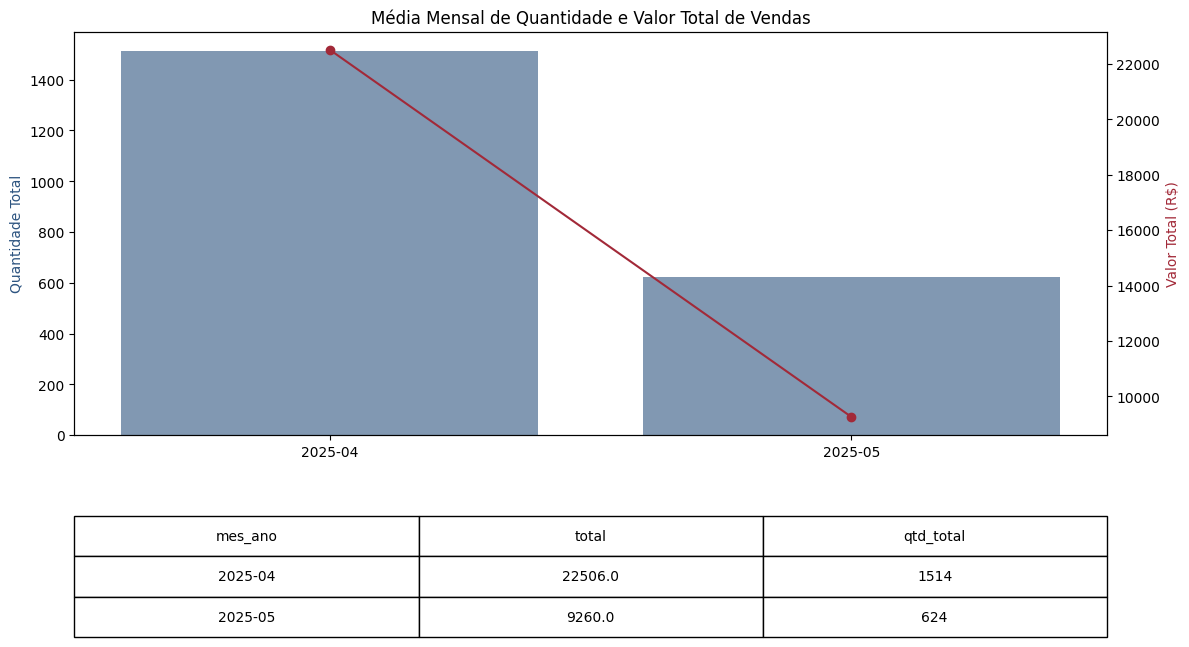

In [35]:
# Calcular qtd_total e ticket_medio
df_filtrado['qtd_total'] = df_filtrado[qtd_cols].sum(axis=1)
df_filtrado['ticket_medio'] = df_filtrado['total'] / df_filtrado['qtd_total'].replace(0, np.nan)
df_filtrado['mes_ano'] = df_filtrado['data'].dt.to_period('M')

mensal = df_filtrado.groupby('mes_ano').agg({'total':'sum', 'qtd_total':'sum'}).reset_index()
mensal[['total', 'qtd_total']] = mensal[['total', 'qtd_total']].round(2)

fig, ax1 = plt.subplots(figsize=(12,6))

# Barras para quantidade total com cor personalizada azul
ax1.bar(mensal['mes_ano'].astype(str), mensal['qtd_total'], alpha=0.6, label='Qtd Total', color=util.barra_azul)
ax1.set_ylabel('Quantidade Total', color=util.barra_azul)

# Linha para valor total com cor personalizada vermelha
ax2 = ax1.twinx()
ax2.plot(mensal['mes_ano'].astype(str), mensal['total'], color=util.barra_vermelha, marker='o', label='Valor Total')
ax2.set_ylabel('Valor Total (R$)', color=util.barra_vermelha)

plt.title('Média Mensal de Quantidade e Valor Total de Vendas')
plt.xticks(rotation=45)

# Criar tabela com as últimas 7 linhas da tabela mensal
table_data = mensal.tail(7).copy()
table_data['mes_ano'] = table_data['mes_ano'].astype(str)
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()

### Pareto das fazendas - contribuição para receita total

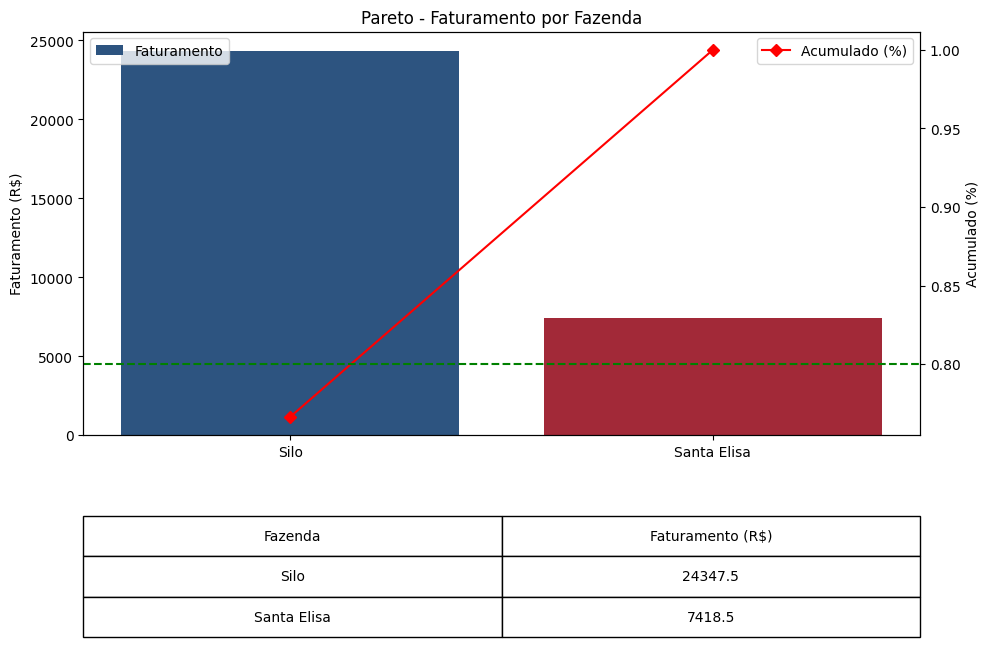

In [44]:
# Calcular faturamento por fazenda e acumulado percentual
faturamento_fazendas = df_filtrado.groupby('fazenda')['total'].sum().sort_values(ascending=False)
cumul = faturamento_fazendas.cumsum() / faturamento_fazendas.sum()

fig, ax = plt.subplots(figsize=(10,6))

# Cores personalizadas para as barras: alternando azul e vermelho
cores = [util.barra_azul if i % 2 == 0 else util.barra_vermelha for i in range(len(faturamento_fazendas))]
bars = ax.bar(faturamento_fazendas.index, faturamento_fazendas.values, color=cores, label='Faturamento')

ax2 = ax.twinx()
ax2.plot(faturamento_fazendas.index, cumul.values, color='red', marker='D', label='Acumulado (%)')
ax2.axhline(0.8, color='green', linestyle='--')

ax.set_ylabel('Faturamento (R$)')
ax2.set_ylabel('Acumulado (%)')
plt.title('Pareto - Faturamento por Fazenda')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)

# Criar tabela com as últimas 7 fazendas na ordem de faturamento
table_data = faturamento_fazendas.tail(7).reset_index()
table_data.columns = ['Fazenda', 'Faturamento (R$)']
table_data['Faturamento (R$)'] = table_data['Faturamento (R$)'].round(2)

table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()

### Desvio padrão diário das refeições por fazenda

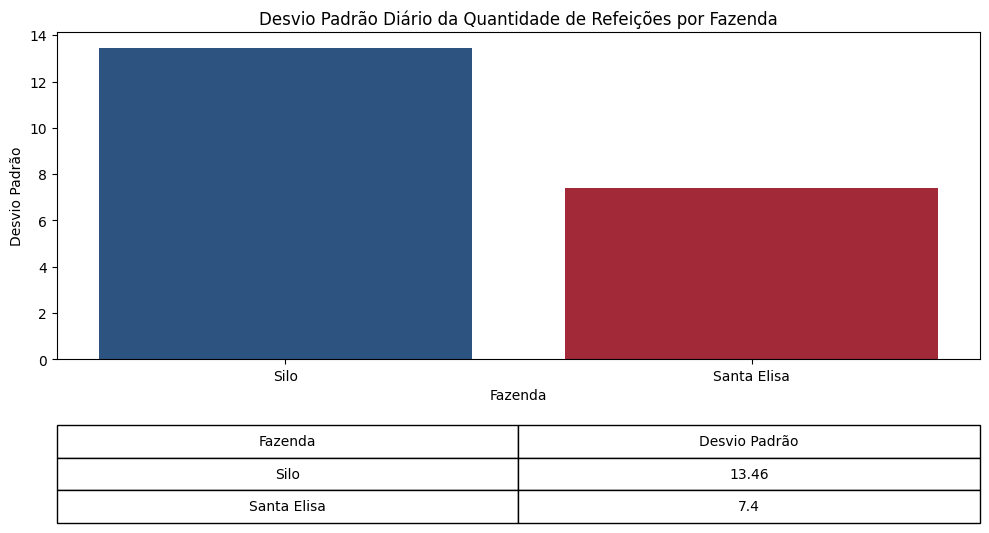

In [37]:
# Calcular desvio padrão diário da quantidade total de refeições por fazenda
variacao = (
    df_filtrado.groupby(['fazenda', 'data'])['qtd_total'].sum()
    .groupby('fazenda').std()
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(10, 5))

# Cores alternadas para as barras
cores = [util.barra_azul if i % 2 == 0 else util.barra_vermelha for i in range(len(variacao))]
bars = ax.bar(variacao.index, variacao.values, color=cores)

ax.set_title('Desvio Padrão Diário da Quantidade de Refeições por Fazenda')
ax.set_ylabel('Desvio Padrão')
ax.set_xlabel('Fazenda')
plt.xticks(rotation=0)

# Criar tabela com as 7 maiores variações (desvio padrão)
table_data = variacao.head(7).reset_index()
table_data.columns = ['Fazenda', 'Desvio Padrão']
table_data['Desvio Padrão'] = table_data['Desvio Padrão'].round(2)

table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()

### Ticket médio por tipo de refeição e fazenda

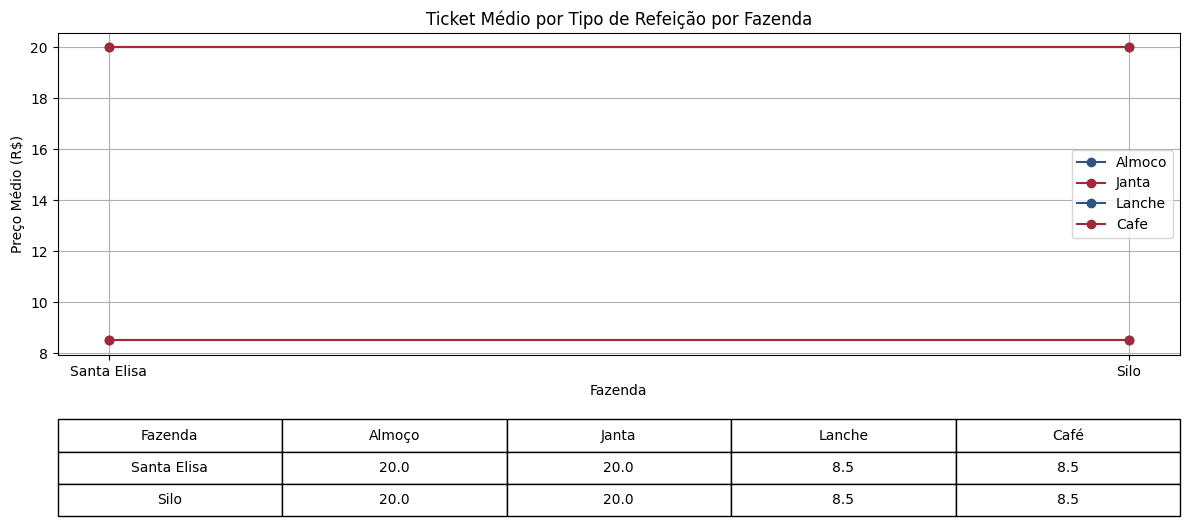

In [38]:
vlr_cols = ['vlralmoco', 'vlrjanta', 'vlrlanche', 'vlrcafe']

# Criar dataframe com valores por tipo e fazenda
ticket_tipo = pd.DataFrame()
for i, qtd in enumerate(qtd_cols):
    tipo = qtd.replace('qtd', '')
    ticket_tipo[tipo] = df_filtrado[vlr_cols[i]]  # preço médio por tipo
ticket_tipo['fazenda'] = df_filtrado['fazenda']
ticket_tipo['total_qtd'] = df_filtrado[qtd_cols].sum(axis=1)
ticket_tipo['ticket_medio'] = df_filtrado['ticket_medio']

# Média do ticket por fazenda
media_ticket_fazenda = ticket_tipo.groupby('fazenda').mean()

# Esquema de cores
cores_personalizadas = [util.barra_azul, util.barra_vermelha]

plt.figure(figsize=(12, 6))

for i, tipo in enumerate(['almoco', 'janta', 'lanche', 'cafe']):
    cor = cores_personalizadas[i % 2]
    plt.plot(media_ticket_fazenda.index, media_ticket_fazenda[tipo], marker='o', label=tipo.capitalize(), color=cor)

plt.title('Ticket Médio por Tipo de Refeição por Fazenda')
plt.xlabel('Fazenda')
plt.ylabel('Preço Médio (R$)')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()

# Tabela das 7 fazendas com maior ticket médio geral
media_ticket_fazenda['ticket_medio_geral'] = media_ticket_fazenda[['almoco', 'janta', 'lanche', 'cafe']].mean(axis=1)
table_data = media_ticket_fazenda.sort_values('ticket_medio_geral', ascending=False).head(7).reset_index()

table_display = table_data[['fazenda', 'almoco', 'janta', 'lanche', 'cafe']]
table_display = table_display.round(2)
table_display.columns = ['Fazenda', 'Almoço', 'Janta', 'Lanche', 'Café']

table = plt.table(cellText=table_display.values,
                  colLabels=table_display.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.4)
plt.show()

### Clusterização simples por fazenda

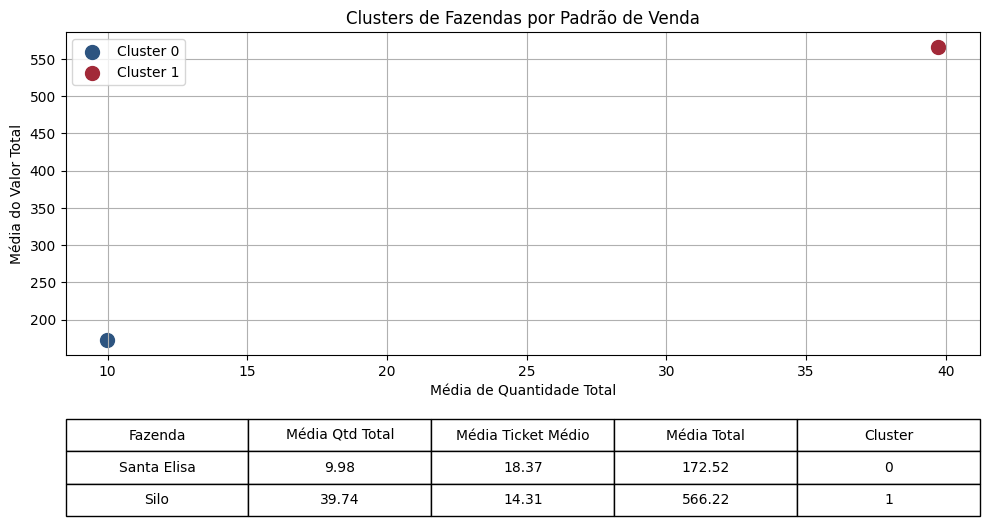

In [39]:
# Preparar dados das features agrupadas por fazenda
features = df_filtrado.groupby('fazenda').agg({
    'qtd_total': 'mean',
    'ticket_medio': 'mean',
    'total': 'mean'
}).dropna()

# Rodar KMeans com 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features)
features['cluster'] = clusters

# Esquema de cores personalizado para clusters
cores_personalizadas = [util.barra_azul, util.barra_vermelha]

plt.figure(figsize=(10,6))
for c in features['cluster'].unique():
    cluster_data = features[features['cluster'] == c]
    plt.scatter(cluster_data['qtd_total'], cluster_data['total'], 
                label=f'Cluster {c}', color=cores_personalizadas[c], s=100)

plt.xlabel('Média de Quantidade Total')
plt.ylabel('Média do Valor Total')
plt.title('Clusters de Fazendas por Padrão de Venda')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Preparar tabela com valores arredondados
table_data = features.reset_index()
table_display = table_data.round(2)
table_display.columns = ['Fazenda', 'Média Qtd Total', 'Média Ticket Médio', 'Média Total', 'Cluster']

# Criar tabela abaixo do gráfico
table = plt.table(cellText=table_display.values,
                  colLabels=table_display.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.4)
plt.show()

### #Participação percentual de cada tipo de refeição por fazenda


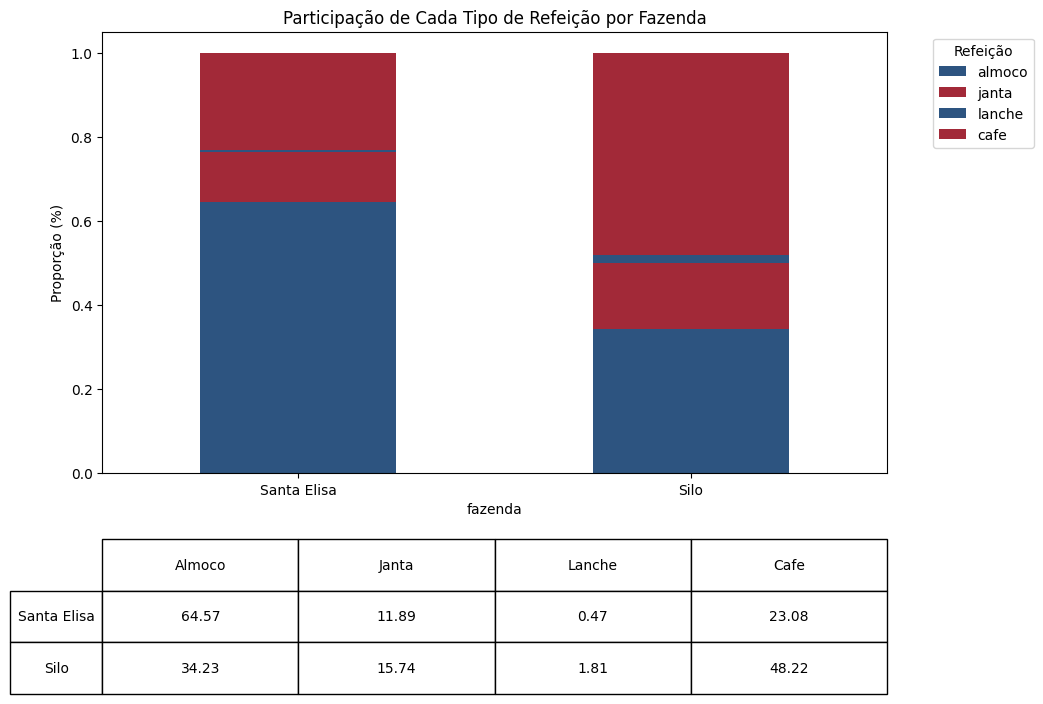

In [41]:
# Calcular total de refeições por fazenda
ref_por_fazenda = df_filtrado.groupby('fazenda')[qtd_cols].sum()

# Calcular participação percentual (proporção) de cada tipo de refeição por fazenda
df_porc = ref_por_fazenda.div(ref_por_fazenda.sum(axis=1), axis=0)

# Preparar cores personalizadas para as barras empilhadas
n_tipos = len(df_porc.columns)
cores = [cores_personalizadas[i % len(cores_personalizadas)] for i in range(n_tipos)]

# Plot gráfico de barras empilhadas com cores personalizadas
ax = df_porc.plot(kind='bar', stacked=True, figsize=(12, 6), color=cores)

plt.title('Participação de Cada Tipo de Refeição por Fazenda')
plt.ylabel('Proporção (%)')
plt.legend(title='Refeição', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=0)

# Criar tabela com as últimas 7 fazendas, arredondado para 2 casas decimais e convertido para %
df_tabela = (df_porc.tail(7) * 100).round(2)

plt.table(cellText=df_tabela.values,
          rowLabels=df_tabela.index,
          colLabels=[c.replace('qtd', '').capitalize() for c in qtd_cols],
          cellLoc='center',
          rowLoc='center',
          loc='bottom',
          bbox=[0, -0.5, 1, 0.35])

plt.show()


### Tendência da quantidade de refeições ao longo do tempo (média móvel de 7 dias)

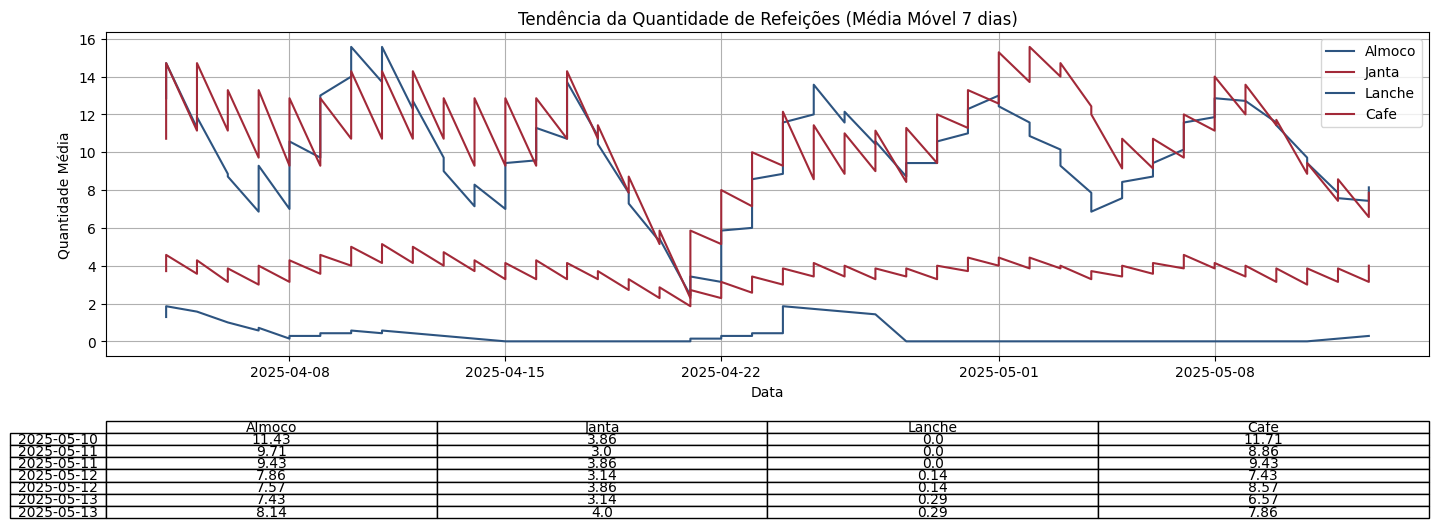

In [42]:
# Calcular média móvel de 7 dias para as colunas de quantidade
df_data = df_filtrado.set_index('data').sort_index()
media_movel = df_data[qtd_cols].rolling(window=7).mean()

# Agora o código para plotar com cores e tabela
import matplotlib.pyplot as plt

cores_personalizadas = [util.barra_azul, util.barra_vermelha]

plt.figure(figsize=(14, 6))

for i, col in enumerate(qtd_cols):
    cor = cores_personalizadas[i % len(cores_personalizadas)]
    plt.plot(media_movel.index, media_movel[col], label=col.replace('qtd', '').capitalize(), color=cor)

plt.title('Tendência da Quantidade de Refeições (Média Móvel 7 dias)')
plt.xlabel('Data')
plt.ylabel('Quantidade Média')
plt.legend()
plt.grid(True)
plt.tight_layout(rect=[0, 0.3, 1, 1])

ultimos_7_dias = media_movel.tail(7).round(2)

plt.table(cellText=ultimos_7_dias.values,
          rowLabels=ultimos_7_dias.index.strftime('%Y-%m-%d'),
          colLabels=[c.replace('qtd', '').capitalize() for c in qtd_cols],
          cellLoc='center',
          rowLoc='center',
          loc='bottom',
          bbox=[0, -0.5, 1, 0.3])

plt.show()


### Identificação de dias com vendas anormais (outliers de total vendido)

⚠️ Nenhum outlier encontrado para exibir na tabela.


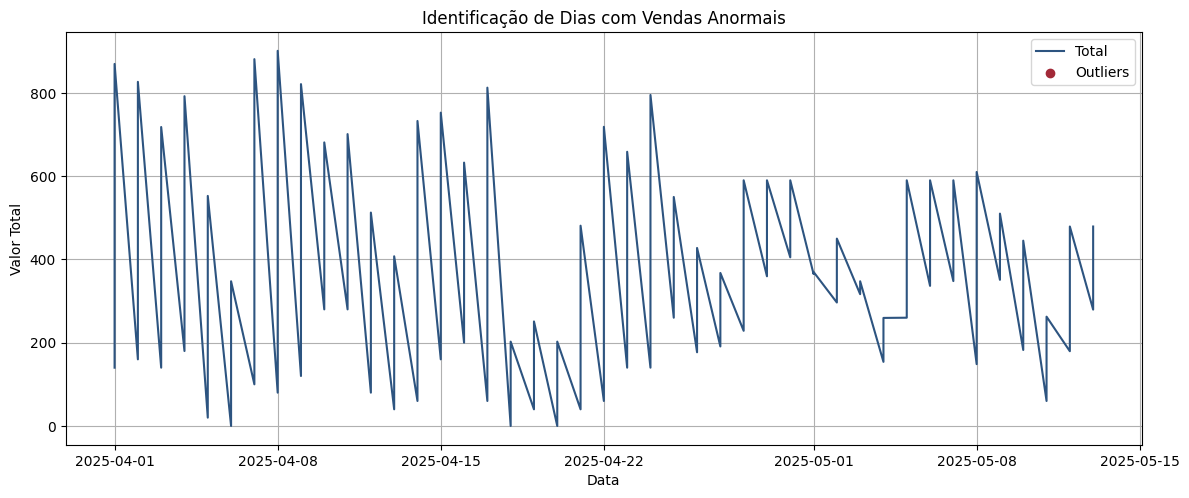

In [46]:
# Cálculo dos outliers com base no IQR do total vendido
q1 = df_filtrado['total'].quantile(0.25)
q3 = df_filtrado['total'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = df_filtrado[(df_filtrado['total'] < limite_inferior) | (df_filtrado['total'] > limite_superior)]

# Definindo as cores
cores = [util.barra_azul, util.barra_vermelha]

# Plot principal com linha e pontos dos outliers
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado['data'], df_filtrado['total'], color=cores[0], label='Total')
plt.scatter(outliers['data'], outliers['total'], color=cores[1], label='Outliers', zorder=5)
plt.title('Identificação de Dias com Vendas Anormais')
plt.xlabel('Data')
plt.ylabel('Valor Total')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Criar tabela com os últimos 7 outliers
tabela_outliers = outliers[['data', 'total']].tail(7).copy()

if not tabela_outliers.empty:
    tabela_outliers['data'] = tabela_outliers['data'].dt.strftime('%Y-%m-%d')

    plt.table(cellText=tabela_outliers.values,
              colLabels=['Data', 'Valor Total'],
              cellLoc='center',
              rowLoc='center',
              loc='bottom',
              bbox=[0, -0.5, 1, 0.3])

    plt.subplots_adjust(bottom=0.25)
else:
    print("⚠️ Nenhum outlier encontrado para exibir na tabela.")

plt.subplots_adjust(bottom=0.25)  # Ajusta o espaço para a tabela aparecer
plt.show()

### Evolução do ticket médio por tipo de refeição ao longo do tempo

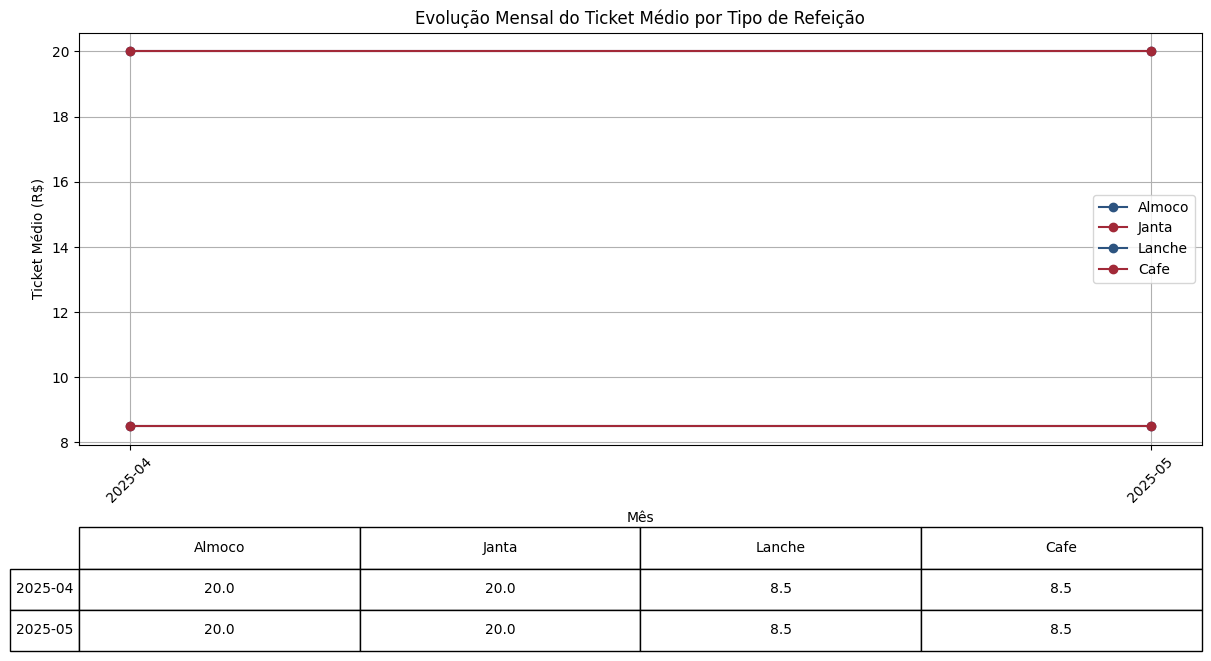

In [47]:
# 11. Evolução do ticket médio por tipo de refeição ao longo do tempo
df_filtrado['mes_ano'] = df_filtrado['data'].dt.to_period('M')
ticket_mensal = df_filtrado.groupby('mes_ano')[vlr_cols].mean()

# Definição das cores personalizadas
cores = [util.barra_azul, util.barra_vermelha]

plt.figure(figsize=(12, 6))
for i, col in enumerate(vlr_cols):
    plt.plot(ticket_mensal.index.astype(str), ticket_mensal[col], 
             marker='o', label=col.replace('vlr', '').capitalize(),
             color=cores[i % len(cores)])

plt.title('Evolução Mensal do Ticket Médio por Tipo de Refeição')
plt.xlabel('Mês')
plt.ylabel('Ticket Médio (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)


# Preparar tabela com últimas 7 linhas do ticket_mensal (formatar índice como string)
tabela = ticket_mensal.tail(7).copy()
tabela.index = tabela.index.astype(str)

plt.table(cellText=tabela.values,
          rowLabels=tabela.index,
          colLabels=[c.replace('vlr', '').capitalize() for c in tabela.columns],
          cellLoc='center',
          rowLoc='center',
          loc='bottom',
          bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.25)  # Espaço para tabela
plt.show()


### Comparação da média de refeições durante a semana vs fim de semana

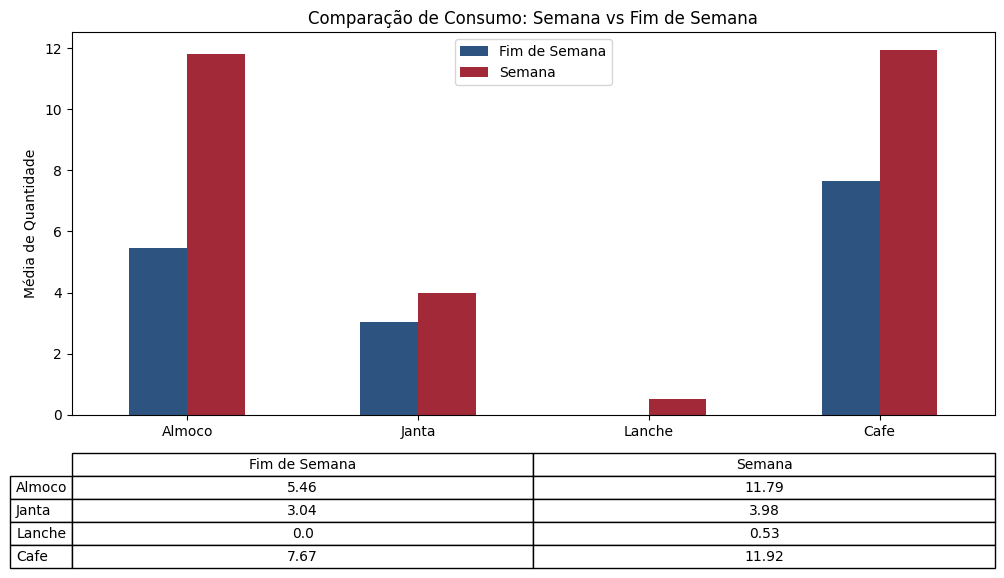

In [48]:
# Recalcular para garantir consistência
df_filtrado['dia'] = df_filtrado['data'].dt.dayofweek
df_filtrado['semana_fds'] = df_filtrado['dia'].apply(lambda x: 'Semana' if x < 5 else 'Fim de Semana')

# Média de refeições por tipo no período
media_semana = df_filtrado.groupby('semana_fds')[qtd_cols].mean().T
media_semana.columns.name = None
media_semana.index = [col.replace('qtd', '').capitalize() for col in media_semana.index]

# Cores personalizadas para as barras
cores = [util.barra_azul, util.barra_vermelha]

# Gráfico de barras comparando semana vs fim de semana
media_semana.plot(kind='bar', figsize=(10, 6), color=cores)
plt.title('Comparação de Consumo: Semana vs Fim de Semana')
plt.ylabel('Média de Quantidade')
plt.xticks(rotation=0)
plt.tight_layout()

# Tabela com os dados usados no gráfico
cell_text = media_semana.round(2).values
col_labels = media_semana.columns
row_labels = media_semana.index

plt.table(cellText=cell_text,
          rowLabels=row_labels,
          colLabels=col_labels,
          cellLoc='center',
          loc='bottom',
          bbox=[0, -0.4, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()


### #Séries Temporais por Tipo de Refeição (Previsão)

/home/rafael/App/dashboard_elisaagro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing


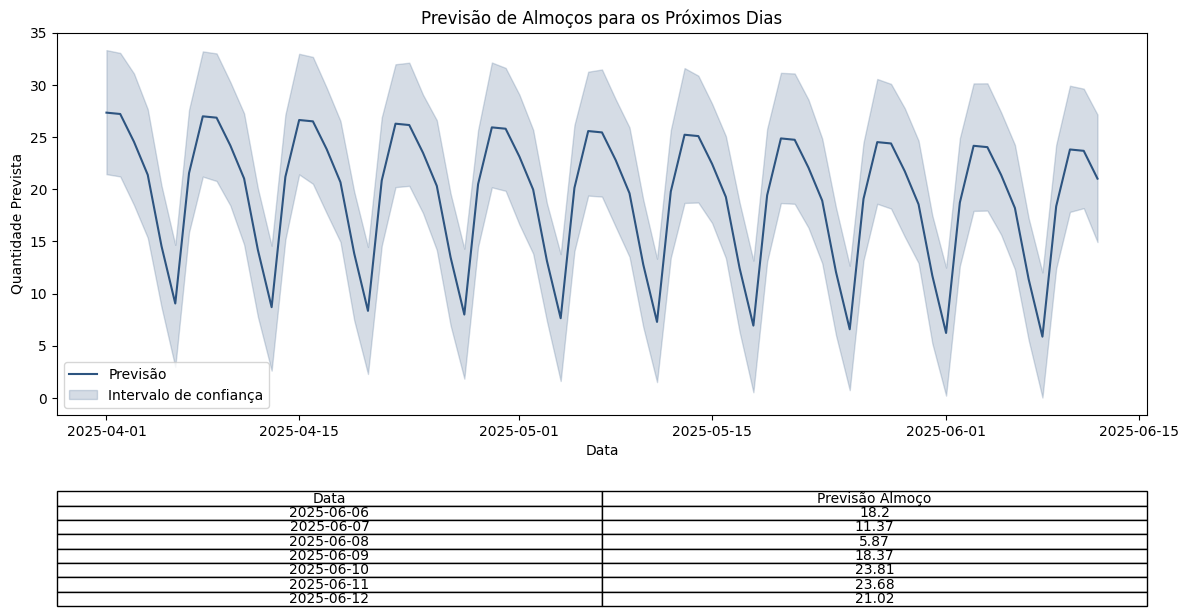

In [49]:
from prophet import Prophet

# Série de almoço
df_almoco = df_filtrado.groupby('data')['almoco'].sum().reset_index()
df_almoco.columns = ['ds', 'y']

modelo_almoco = Prophet()
modelo_almoco.fit(df_almoco)

futuro_almoco = modelo_almoco.make_future_dataframe(periods=30)
previsao_almoco = modelo_almoco.predict(futuro_almoco)

# Gráfico com cor personalizada
plt.figure(figsize=(12, 6))
plt.plot(previsao_almoco['ds'], previsao_almoco['yhat'], color=util.barra_azul, label='Previsão')
plt.fill_between(previsao_almoco['ds'], previsao_almoco['yhat_lower'], previsao_almoco['yhat_upper'],
                 color=util.barra_azul, alpha=0.2, label='Intervalo de confiança')
plt.title('Previsão de Almoços para os Próximos Dias')
plt.xlabel('Data')
plt.ylabel('Quantidade Prevista')
plt.legend()
plt.tight_layout()

# Tabela com os últimos 7 dias previstos
tabela_prev_almoco = previsao_almoco[['ds', 'yhat']].tail(7).copy()
tabela_prev_almoco['ds'] = tabela_prev_almoco['ds'].dt.strftime('%Y-%m-%d')
tabela_prev_almoco['yhat'] = tabela_prev_almoco['yhat'].round(2)

plt.table(cellText=tabela_prev_almoco.values,
          colLabels=['Data', 'Previsão Almoço'],
          cellLoc='center',
          loc='bottom',
          bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()





12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing


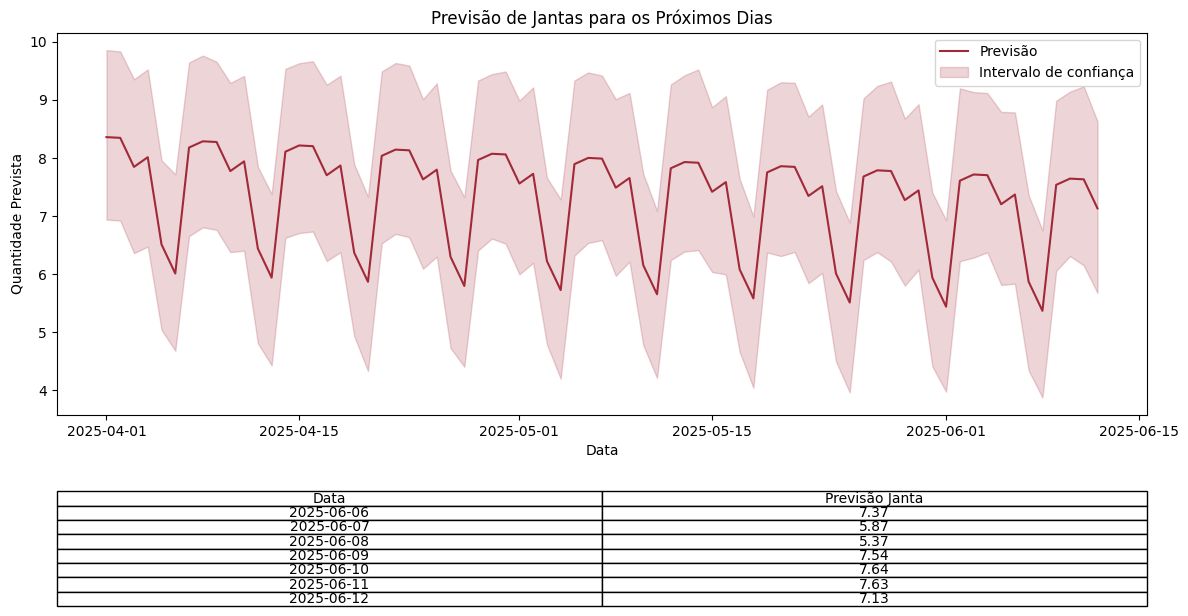

In [50]:
# Série de janta
df_janta = df_filtrado.groupby('data')['janta'].sum().reset_index()
df_janta.columns = ['ds', 'y']

modelo_janta = Prophet()
modelo_janta.fit(df_janta)

futuro_janta = modelo_janta.make_future_dataframe(periods=30)
previsao_janta = modelo_janta.predict(futuro_janta)

# Gráfico com cor personalizada
plt.figure(figsize=(12, 6))
plt.plot(previsao_janta['ds'], previsao_janta['yhat'], color=util.barra_vermelha, label='Previsão')
plt.fill_between(previsao_janta['ds'], previsao_janta['yhat_lower'], previsao_janta['yhat_upper'],
                 color=util.barra_vermelha, alpha=0.2, label='Intervalo de confiança')
plt.title('Previsão de Jantas para os Próximos Dias')
plt.xlabel('Data')
plt.ylabel('Quantidade Prevista')
plt.legend()
plt.tight_layout()

# Tabela com os últimos 7 dias previstos
tabela_prev_janta = previsao_janta[['ds', 'yhat']].tail(7).copy()
tabela_prev_janta['ds'] = tabela_prev_janta['ds'].dt.strftime('%Y-%m-%d')
tabela_prev_janta['yhat'] = tabela_prev_janta['yhat'].round(2)

plt.table(cellText=tabela_prev_janta.values,
          colLabels=['Data', 'Previsão Janta'],
          cellLoc='center',
          loc='bottom',
          bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.show()

### detecca de anomalia valor total de refeicoes


⚠️ Nenhuma anomalia foi detectada com z-score > 3.


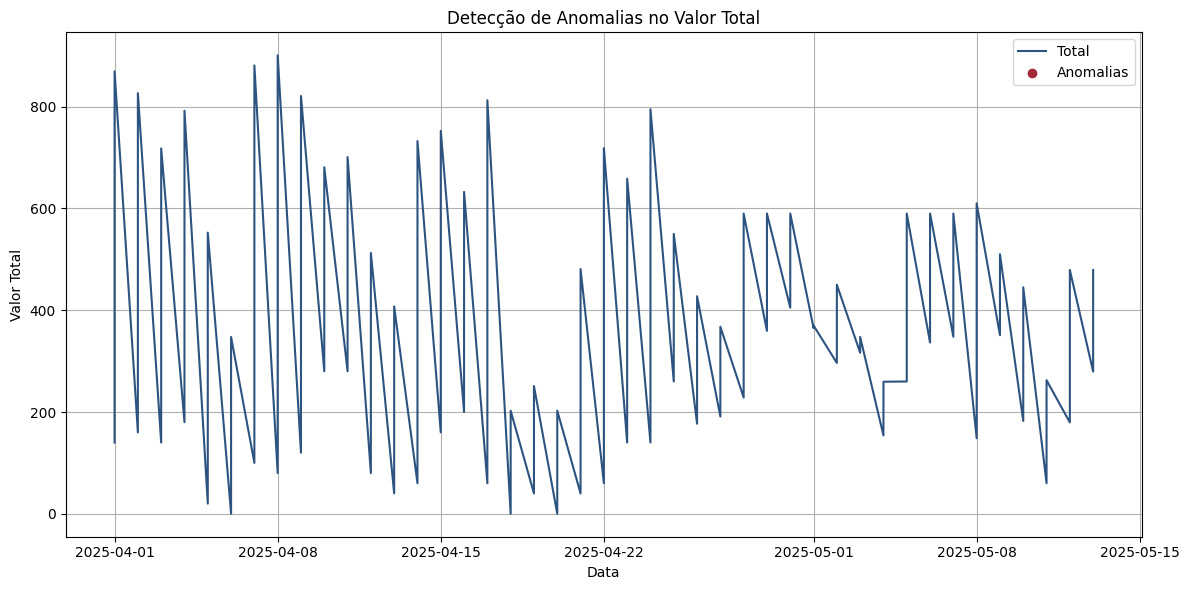

In [55]:
from scipy.stats import zscore

# Calcular z-score e identificar anomalias
df_filtrado['z_total'] = zscore(df_filtrado['total'])
anomalias = df_filtrado[df_filtrado['z_total'].abs() > 3]

# Plot com cores personalizadas
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado['data'], df_filtrado['total'], color=util.barra_azul, label='Total')
plt.scatter(anomalias['data'], anomalias['total'], color=util.barra_vermelha, label='Anomalias', zorder=5)
plt.title('Detecção de Anomalias no Valor Total')
plt.xlabel('Data')
plt.ylabel('Valor Total')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Tabela com os últimos 7 outliers (com verificação de existência)
tabela_anomalias = anomalias[['data', 'total']].tail(7).copy()

if not tabela_anomalias.empty:
    tabela_anomalias['data'] = tabela_anomalias['data'].dt.strftime('%Y-%m-%d')
    tabela_anomalias['total'] = tabela_anomalias['total'].round(2)

    plt.table(cellText=tabela_anomalias.values,
              colLabels=['Data', 'Valor Total'],
              cellLoc='center',
              loc='bottom',
              bbox=[0, -0.5, 1, 0.3])

    plt.subplots_adjust(bottom=0.3)
else:
    print("⚠️ Nenhuma anomalia foi detectada com z-score > 3.")

plt.show()